# Package Imports

In [1]:
from pathlib import Path
import sys

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymodulon.io import load_json_model
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
import shap
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm

from Bio.SeqUtils import GC
from Bio.motifs import matrix

from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score

import xgboost as xgb

import pickle

#sys.path.append('bitome2')
#sys.path.append('')
sys.path.append('../../bitome2')
sys.path.append('../')

from bitome.core import Bitome
from bitome.ml import *
from bitome.util import *

sns.set_style('whitegrid')

shap.initjs()

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# RNG Setup

In [2]:
# Using RandomState instead of a generator since sklearn does not work with 
# np.random.generator instances yet
rng = np.random.RandomState(seed = 42)
seed_set = 42;

# Function definitions

In [3]:
def one_hot_encode_sequence_manual(sequence: str) -> pd.Series:

        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(sequence):
            for base in 'ACGT':
                one_hot_names.append(f'{i}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

In [4]:
'''

def one_hot_encode_sequence_manual(sequence: str, feature: str) -> pd.Series:
        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(sequence):
            for base in 'ACGT':
                one_hot_names.append(f'{feature}_{i}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

# DataFrame to hold the one-hot encoded features
urtecho_one_hot = pd.DataFrame(index = urtecho_expression.index)

for feature, sequence in urtecho_expression.iloc[:, 2:].items():
    feature_one_hot = sequence.apply(one_hot_encode_sequence_manual, args = (feature,))
    urtecho_one_hot = pd.concat(
        objs = [urtecho_one_hot, feature_one_hot],
        ignore_index = False,
        axis = 1,
    )
    '''

"\n\ndef one_hot_encode_sequence_manual(sequence: str, feature: str) -> pd.Series:\n        one_hot_names = []\n        one_hots = []\n        for i, seq_base in enumerate(sequence):\n            for base in 'ACGT':\n                one_hot_names.append(f'{feature}_{i}_{base}')\n                if base == seq_base:\n                    one_hots.append(1)\n                else:\n                    one_hots.append(0)\n\n        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)\n        return one_hot_sequence\n\n# DataFrame to hold the one-hot encoded features\nurtecho_one_hot = pd.DataFrame(index = urtecho_expression.index)\n\nfor feature, sequence in urtecho_expression.iloc[:, 2:].items():\n    feature_one_hot = sequence.apply(one_hot_encode_sequence_manual, args = (feature,))\n    urtecho_one_hot = pd.concat(\n        objs = [urtecho_one_hot, feature_one_hot],\n        ignore_index = False,\n        axis = 1,\n    )\n    "

In [5]:
def calc_sliding_rigidity(seq):
    rigidity = 0

    persistence = {
    'AA' : 50.4, 'TT' : 50.4, #revcomp
    'AC':  55.4, 'GT' : 55.4, #revcomp
    'AG':  51.0, 'CT' : 51.0, #revcomp
    'AT':  40.9,
    'CA':  46.7, 'TG' : 46.7, #revcomp
    'CC':  41.7, 'GG' : 41.7, #revcomp
    'CG':  56.0,
    'GA':  54.4, 'TC' : 54.4, #revcomp
    'GC':  44.6,
    'TA':  44.7,
}
    
    for i in range(len(seq) - 1):
        window = seq[i:i+2]
        rigidity += persistence[window]
    
    return rigidity / (len(seq) - 1)

In [6]:
#THIS FUNCTION HARD CODES THE BITOME STRUCTURE
def one_hot_encode_sequence(left: int, right: int, strand: int) -> pd.Series:
    
        #sequence = bitome_genbank.get_sequence(left, right, strand)
        #I added this check because it broke the code if the orientation was wrong
        if left > right:
            left_temp = left
            left = right
            right = left_temp
        sequence = mg1655.get_sequence(left, right, strand)
        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(sequence):
            for base in 'ACGT':
                one_hot_names.append(f'{i}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

In [7]:
def one_hot_sequence_left_padding(left: int) -> pd.Series:
    if left == 0:
        return pd.Series()
    
    one_hot_names = []
    one_hots = [] 
    for i in range(1,left+1):
        for base in ('ACGT'):
            one_hots.append(0)
            one_hot_names.append(f'{0-i}_{base}')
        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence

In [8]:
def reindex_one_hot(old_names, upstream, downstream, prefix=''):
    new_names = []
    for old_name,j in zip(old_names, [x for x in range(-upstream, downstream+1) for _ in range(4)]):
        ind, base = old_name.split('_')
        new_ind = j
        new_name = f'{prefix}{new_ind}_{base}'
        new_names.append(new_name)
    return new_names

In [9]:
def one_hot_sequence_right_padding(right: int, spacer_len_oh: int) -> pd.Series:
    if right == 0:
        return pd.Series()
    
    one_hot_names = []
    one_hots = [] 
    for i in range(1,right+1):
        for base in ('ACGT'):
            one_hots.append(0)
            one_hot_names.append(f'{(int(spacer_len_oh/4)-1)+i}_{base}')
        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
    return one_hot_sequence

In [10]:
def reindex_one_hot_spacer(old_names, upstream, downstream, strand, prefix=''):
    new_names = []
    for old_name,j in zip(old_names, [x for x in range(-upstream, downstream+1) for _ in range(4)][::-1]):
        ind, base = old_name.split('_')
        new_ind = j
        new_name = f'{prefix}{new_ind}_{base}'
        new_names.append(new_name)
    return new_names

In [11]:
def generate_spacer_one_hot(tu_row):
    spacer_u, spacer_d = (tu_row.box_35_right+1, tu_row.box_10_left-1) if tu_row.strand == 1 else (
    tu_row.box_10_right+1, tu_row.box_35_left-1)
    spacer_oh = one_hot_encode_sequence(spacer_u, spacer_d, tu_row.strand)
    
    length = len(spacer_oh) // 4
    if length % 2 == 0:
        left = int((26 - length) / 2)
        right = int((26 - length) / 2)
    else:
        left = int((26 - length) / 2)
        right = int((26 - length) // 2) + 1
    spacer_ohh = pd.concat([one_hot_sequence_left_padding(left=left), spacer_oh,
                               one_hot_sequence_right_padding(right=right, spacer_len_oh=length)])

    return spacer_ohh

In [12]:
def one_hot_encode_tu_promoters_banked(self, local_align: bool = False,
                                    n_upstream: int = 50, n_downstream: int = 10,
                                    tss_radius: int = 3, box_10_radius: int = 6,
                                    box_35_radius: int = 6, shift_odd_len_upstream: bool = True
                                    ) -> pd.DataFrame:
        """
        High-level utility function to prepare a data matrix with all TUs (tu_table must be set)
        converted into one-hot sequences. Uses one_hot_encode_sequence under the hood.

        :param bool local_align: indicates if the one-hot encoding should include local regions
            centered around the specific annotated locations of key promoter features: TSS (CRE),
            -10 box, -35 box
        :param int n_upstream: the number of bases upstream from a TSS to include; only used if
            local_align is False; defaults to 50
        :param int n_downstream: the number of bases downstream from a TSS to include; only used if
            local_align is False, defaults to 10
        :param int tss_radius: the number of base pairs up and downstream of the TSS to one-hot
            encode (NOTE: this parameter is in ONE direction, so the final range will be double the
            size of this parameter, plus the TSS itself); only used if local_align is True
        :param int box_10_radius: the number of base pairs up and downstream of the center of the
            -10 box to one-hot encode; this box is typically a hexamer, so the center point will be
            between the 2 central nucleotides; if a box annotation has odd length, it will be
            shifted to ensure alignment with the even-length boxes. The direction of this shift can
            be controlled with shift_odd_len_upstream. Only used if local_align is True
        :param int box_35_radius: the number of base pairs up and downstream of the center of the
            -35 box to one-hot encode; this box is typically a hexamer, so the center point will be
            between the 2 central nucleotides; if a box annotation has odd length, it will be
            shifted to ensure alignment with the even-length boxes. The direction of this shift can
            be controlled with shift_odd_len_upstream. Only used if local_align is True
        :param bool shift_odd_len_upstream: in order to align odd length promoter boxes, indicates
            if they should be shifted 1 bp upstream (i.e. their "center" is 0.5 bp DOWNSTREAM of the
            central base pair) or 1 bp downstream (i.e. their "center" is 0.5 bp UPSTREAM of the
            central base pair); only used if local_align is True
        :return pd.DataFrame one_hot_tu_df: a DataFrame containing rows with one-hot-encoded TSS
            promoter sequences for all TUs with known TSS
        """

        if self.tu_table.empty:
            raise ValueError('No TU table available.')

        # create a utility that will help us rename one-hot row indices from one_hot_encode_sequence
        def reindex_one_hot(old_names, offset, prefix=''):
            new_names = []
            for old_name in old_names:
                ind, base = old_name.split('_')
                new_ind = int(ind) - offset
                new_name = f'{prefix}{new_ind}_{base}'
                new_names.append(new_name)
            return new_names

        if local_align:
            one_hot_index = []
            one_hot_rows = []
            tu_table_local_align = self.tu_table[
                (self.tu_table['tss'].notna()) &
                (self.tu_table['box_10_left'].notna()) &
                (self.tu_table['box_35_left'].notna())
            ]
            
            for tu_row in tu_table_local_align.itertuples():

                tss_l, tss_r = tu_row.tss - tss_radius, tu_row.tss + tss_radius

                # define a quick utility to appropriately align the (typically) hexamer boxes
                def get_box_mid(box_l, box_r, strand):
                    box_mid = location_to_point(box_l, box_r, strand, 'midpoint')
                    # adjust the midpoint if the box has an odd length
                    if (box_r - box_l) % 2 == 1:
                        if shift_odd_len_upstream:
                            box_mid = box_mid + 0.5 * strand
                        else:
                            box_mid = box_mid - 0.5 * strand
                    return box_mid

                # ceiling/floor handles the case of even length
                b10_mid = get_box_mid(tu_row.box_10_left, tu_row.box_10_right, tu_row.strand)
                b10_l, b10_r = np.ceil(b10_mid - box_10_radius), np.floor(b10_mid + box_10_radius)
                b35_mid = get_box_mid(tu_row.box_35_left, tu_row.box_35_right, tu_row.strand)
                b35_l, b35_r = np.ceil(b35_mid - box_35_radius), np.floor(b35_mid + box_35_radius)

                tss_oh = self.one_hot_encode_sequence(tss_l, tss_r, tu_row.strand)
                tss_oh.index = reindex_one_hot(tss_oh.index, tss_radius, prefix='tss_')
                box_10_oh = self.one_hot_encode_sequence(b10_l, b10_r, tu_row.strand)
                box_10_oh.index = reindex_one_hot(box_10_oh.index, box_10_radius, prefix='-10_')
                box_35_oh = self.one_hot_encode_sequence(b35_l, b35_r, tu_row.strand)
                box_35_oh.index = reindex_one_hot(box_35_oh.index, box_35_radius, prefix='-35_')
                full_oh_row = pd.concat([tss_oh, box_10_oh, box_35_oh])

                one_hot_index.append(tu_row.Index)
                one_hot_rows.append(full_oh_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

        else:
            one_hot_index = []
            one_hot_rows = []
            tu_table_tss = self.tu_table[self.tu_table['tss'].notna()]
            for tu_row in tu_table_tss.itertuples():
                one_hot_index.append(tu_row.Index)
                if tu_row.strand == 1:
                    left, right = tu_row.tss - n_upstream, tu_row.tss + n_downstream
                else:
                    left, right = tu_row.tss - n_downstream, tu_row.tss + n_upstream
                one_hot_row = self.one_hot_encode_sequence(left, right, tu_row.strand)
                one_hot_rows.append(one_hot_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

            # adjust the column names to reflect the locations relative to the TSS
            one_hot_tu_df.columns = reindex_one_hot(one_hot_tu_df.columns, n_upstream)

        return one_hot_tu_df

In [13]:
def one_hot_encode_tu_promoters(tu_table, local_align: bool = False,
                                    upstream: int = 0, downstream: int = 0,
                                    box_10_l: bool = False, box_10_r: bool = False,
                                    box_35_l: bool = False, box_35_r: bool = False, 
                                    tss: bool = False, tfbs_l: bool = False, tfbs_r: bool = False, spacer: bool = False,
                                    tss_up: int = 0, tss_dn: int = 0,
                                    box_10_l_up: int = 0, box_10_l_dn: int = 0,
                                    box_10_r_up: int = 0, box_10_r_dn: int = 0,
                                    box_35_l_up: int = 0, box_35_l_dn: int = 0,
                                    box_35_r_up: int = 0, box_35_r_dn: int = 0,
                                    ) -> pd.DataFrame:
        
        a = []
        tss_oh, box_10_l_oh, box_10_r_oh, box_35_l_oh, box_35_r_oh, spacer_ohh = [None] * 6
        
        if local_align:
            one_hot_index = []
            one_hot_rows = []
            tu_table_local_align = tu_table[
                (tu_table['tss'].notna()) &
                (tu_table['box_10_left'].notna()) &
                (tu_table['box_35_left'].notna())
            ]
            
            #tu_table_local_align = tu_table[
            #    (tu_table['tss'].notna())
            #]
            
            for tu_row in tu_table_local_align.itertuples():
                

                if spacer:
                    spacer_ohh = generate_spacer_one_hot(tu_row)
                    spacer_ohh.index = reindex_one_hot_spacer(spacer_ohh.index, 0, 25, strand = tu_row.strand, prefix='spacer_')
                
                if tss:
                    if tu_row.strand == 1:
                        tss_u, tss_d = tu_row.tss - tss_up, tu_row.tss + tss_dn
                    else:
                        tss_u, tss_d = tu_row.tss - tss_dn, tu_row.tss + tss_up
                    tss_oh = one_hot_encode_sequence(tss_u, tss_d, tu_row.strand)
                    tss_oh.index = reindex_one_hot(tss_oh.index, tss_up, tss_dn, prefix='tss_') #THIS IS A DIFFERENCE - REINDEXING THEM INTO SEPARATE VARIABLES
                
                if box_10_l:
                    if tu_row.strand == 1:
                        box_10_l_u, box_10_l_d = tu_row.box_10_left - box_10_l_up, tu_row.box_10_left + box_10_l_dn
                    else:
                        box_10_l_u, box_10_l_d = tu_row.box_10_right - box_10_l_dn, tu_row.box_10_right + box_10_l_up
                    box_10_l_oh = one_hot_encode_sequence(box_10_l_u, box_10_l_d, tu_row.strand)
                    box_10_l_oh.index = reindex_one_hot(box_10_l_oh.index, box_10_l_up, box_10_l_dn, prefix='m10U_')
                           
                if box_10_r:
                    if tu_row.strand == 1:
                        box_10_r_u, box_10_r_d = tu_row.box_10_right - box_10_r_up, tu_row.box_10_right + box_10_r_dn
                    else:
                        box_10_r_u, box_10_r_d = tu_row.box_10_left - box_10_r_dn, tu_row.box_10_left + box_10_r_up
                    box_10_r_oh = one_hot_encode_sequence(box_10_r_u, box_10_r_d, tu_row.strand)
                    box_10_r_oh.index = reindex_one_hot(box_10_r_oh.index, box_10_r_up, box_10_r_dn, prefix='m10D_')
                                 
                if box_35_l:
                    if tu_row.strand == 1:
                        box_35_l_u, box_35_l_d = tu_row.box_35_left - box_35_l_up, tu_row.box_35_left + box_35_l_dn
                    else:
                        box_35_l_u, box_35_l_d = tu_row.box_35_right - box_35_l_dn, tu_row.box_35_right + box_35_l_up
                    box_35_l_oh = one_hot_encode_sequence(box_35_l_u, box_35_l_d, tu_row.strand)
                    box_35_l_oh.index = reindex_one_hot(box_35_l_oh.index, box_35_l_up, box_35_l_dn, prefix='m35U_')
                        
                if box_35_r:
                    if tu_row.strand == 1:
                        box_35_r_u, box_35_r_d = tu_row.box_35_right - box_35_r_up, tu_row.box_35_right + box_35_r_dn
                    else:
                        box_35_r_u, box_35_r_d = tu_row.box_35_left - box_35_r_dn, tu_row.box_35_left + box_35_r_up
                    box_35_r_oh = one_hot_encode_sequence(box_35_r_u, box_35_r_d, tu_row.strand)
                    box_35_r_oh.index = reindex_one_hot(box_35_r_oh.index, box_35_r_up, box_35_r_dn, prefix='m35D_')
                
                dfs_to_concat = [tss_oh, spacer_ohh, box_10_l_oh, box_10_r_oh, box_35_l_oh, box_35_r_oh]
                
                if any(df is not None for df in dfs_to_concat):
                    full_oh_row = pd.concat([df for df in dfs_to_concat if df is not None])
                    #reindices = pd.concat([df.index for df in dfs_to_concat if df is not None])
                
                one_hot_index.append(tu_row.Index) #THESE INDICES GET CHANGED BUT I DON'T THINK TU_ROW.INDEX DOES
                #one_hot_index.append(full_oh_row.index) #MY ATTEMPT AT A "FIX"
                #one_hot_index.append(reindices) #MY ATTEMPT AT A "FIX"
                one_hot_rows.append(full_oh_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)


        else:
            one_hot_index = []
            one_hot_rows = []
            #tu_table_tss = tu_table[tu_table['tss'].notna()]
            
            tu_table_tss = tu_table[
                (tu_table['tss'].notna()) &
                (tu_table['box_10_left'].notna()) &
                (tu_table['box_35_left'].notna())
            ]
            
            for tu_row in tu_table_tss.itertuples():
                one_hot_index.append(tu_row.Index)
                
                if tu_row.strand == 1:
                    left, right = tu_row.tss - upstream, tu_row.tss + downstream
                else:
                    left, right = tu_row.tss - downstream, tu_row.tss + upstream
                    
                one_hot_row = one_hot_encode_sequence(left, right, tu_row.strand)
                one_hot_rows.append(one_hot_row)

            one_hot_tu_df = pd.DataFrame(one_hot_rows, index=one_hot_index)

            # adjust the column names to reflect the locations relative to the TSS
            one_hot_tu_df.columns = reindex_one_hot(one_hot_tu_df.columns, upstream, downstream)
        
        return one_hot_tu_df

In [14]:
def profile_xy_and_models(xy_to_try: Dict[str, Tuple[pd.DataFrame, pd.Series]],
                          models_to_try: Dict[str, Any],
                          scoring: str = 'r2', n_cv: int = 5,
                          x_preprocessing: List[str] = None,
                          y_preprocessing: List[str] = None,
                          verbose: bool = True) -> Tuple[pd.DataFrame, plt.Axes, plt.Axes]:
    """
    This mega-function enables the testing of multiple ML models on multiple Xy datasets for an
    initial understanding of model/feature performances. Multiple different normalizations for the
    X and y can be specified. This function uses a cross-validation approach, so no distinct
    validation set is created (just a training set). Assumes that the xy passed in have already
    been split for training (you can use create_train_and_lockbox_sets for this)

    Output includes plots summarizing the training and testing scores for each of the model/xy
    combinations, as well as a DataFrame containing those same results for further processing.

    :param Dict[str, Tuple[pd.DataFrame, pd.Series]] xy_to_try: a dictionary containing the names
        (keys) and Xy combinations (values, as tuples) to try modeling
    :param Dict[str, Any] models_to_try: the ML models (sklearn estimators) to try
    :param str scoring: the scoring metric to use; defaults to r2
    :param int n_cv: the number of cross validations to perform
    :param List[str] x_preprocessing: a list of pre-processing steps to apply to the feature matrix.
        Options include: 'standard' (standardizing/z-scoring)
    :param List[str] y_preprocessing: a list of pre-processing steps to apply to the targets.
        Options include: 'standard' (standardizing/z-scoring), 'log' (log+1 transform), and
        'standard_log' (apply log then standard transforms in succession)
    :param bool verbose: indicate if status updates should be printed at relevant moments
    """

    # prepare a DataFrame to store the results of the cross-validated comparisons
    profile_result_df = pd.DataFrame(
        columns=['model', 'xy', 'train_score', 'val_score']
    )

    # iterate through model/XY combinations and run a cross-validation in each case
    for model_name, model in models_to_try.items():
        for xy_name, (x_train_raw, y_train_raw) in xy_to_try.items():

            # normalize the X and y as requested by the options;
            x_list = [('X_raw', x_train_raw)]
            if x_preprocessing is not None:
                for x_norm_scheme in x_preprocessing:
                    if x_norm_scheme == 'standard':
                        x_train_standard = StandardScaler().fit_transform(x_train_raw)
                        x_list.append(('X_standard', x_train_standard))
                    # add more x_norm_scheme here
                    else:
                        raise ValueError(f'X normalization scheme {x_norm_scheme} not recognized')
            y_list = [('y_raw', y_train_raw)]
            if y_preprocessing is not None:
                for y_norm_scheme in y_preprocessing:
                    if y_norm_scheme == 'standard':
                        y_train_standard = StandardScaler().fit_transform(
                            y_train_raw.values.reshape(-1, 1)
                        )
                        y_list.append(('y_standard', y_train_standard))
                    elif y_norm_scheme == 'log':
                        y_train_log = np.log2(y_train_raw.values + 1)
                        y_list.append(('y_log', y_train_log))
                    elif y_norm_scheme == 'log10':
                        y_train_log = np.log10(y_train_raw.values + 1).reshape(-1,1)
                        y_list.append(('y_log10', y_train_log))
                    elif y_norm_scheme == 'standard_log':
                        y_train_standard_log = StandardScaler().fit_transform(
                            np.log2(y_train_raw.values + 1).reshape(-1, 1)
                        )
                        y_list.append(('y_standard_log', y_train_standard_log))
                    # add more y_norm_scheme here
                    else:
                        raise ValueError(f'y normalization scheme {y_norm_scheme} not recognized')

            xy_final = {}
            for (x_lab, x_mat), (y_lab, y_mat) in itertools.product(x_list, y_list):
                xy_lab_final = f'{xy_name}__{x_lab}__{y_lab}'
                xy_final[xy_lab_final] = (x_mat, y_mat)

            for xy_full_name, (X_to_use, y_to_use) in xy_final.items():
                _verbose_print(f'{model_name}: {xy_full_name}', verbose)

                cv_result = cross_validate(model, X_to_use, y=y_to_use, cv=n_cv, scoring=scoring,
                                           return_train_score=True, n_jobs=4)

                cv_result_df = pd.DataFrame(data={
                                                'model': model_name,
                                                'xy': xy_full_name,
                                                'train_score': cv_result['train_score'],
                                                'val_score': cv_result['test_score']
                                            })

                profile_result_df = profile_result_df.append(cv_result_df)

    # plot the training and testing results
    _, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

    sns.boxplot(x='model', y='train_score', data=profile_result_df, hue='xy', dodge=True,
                fliersize=0, ax=ax_train)
    sns.swarmplot(x='model', y='train_score', data=profile_result_df, hue='xy', dodge=True,
                  color='black', ax=ax_train)
    handles_train, labels_train = ax_train.get_legend_handles_labels()
    ax_train.legend(handles_train[:int(len(handles_train)/2)],
                    labels_train[:int(len(labels_train)/2)], loc='center left',
                    bbox_to_anchor=(1.05, 0.5))
    ax_train.set_xlabel('')
    ax_train.set_ylabel(f'Training {scoring}', fontsize=13)
    ax_train.set_ylim(0, 1)

    sns.boxplot(x='model', y='val_score', data=profile_result_df, hue='xy', dodge=True,
                fliersize=0, ax=ax_val)
    sns.swarmplot(x='model', y='val_score', data=profile_result_df, hue='xy', dodge=True,
                  color='black', ax=ax_val)
    handles_val, labels_val = ax_val.get_legend_handles_labels()
    ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
                  loc='center left', bbox_to_anchor=(1.05, 0.5))
    ax_val.set_xlabel('')
    ax_val.set_ylabel(f'Validation {scoring}', fontsize=13)
    ax_val.set_ylim(0, 1)

    return profile_result_df, ax_train, ax_val


In [15]:
def _verbose_print(s: str, verbose: bool):
    """
    Print a string based on a Boolean toggle
    """
    if verbose:
        print(s)

In [16]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

In [17]:
#Generator form - not sure how to use this one
#def getKmers(sequence, size, step):    
#  for x in range(0, len(sequence) - size, step):
#    yield sequence[x:x+size]

In [18]:
#THIS FUNCTION HARD CODES THE BITOME STRUCTURE
def kmer_encode_sequence(left: int, right: int, strand: int) -> pd.Series:
    
        #sequence = bitome_genbank.get_sequence(left, right, strand)
        #I added this check because it broke the code if the orientation was wrong
        if left > right:
            left_temp = left
            left = right
            right = left_temp
        sequence = mg1655.get_sequence(left, right, strand)
        one_hot_names = []
        one_hots = []
        for i, seq_base in enumerate(sequence):
            for base in 'ACGT':
                one_hot_names.append(f'{i}_{base}')
                if base == seq_base:
                    one_hots.append(1)
                else:
                    one_hots.append(0)

        one_hot_sequence = pd.Series(one_hots, index=one_hot_names)
        return one_hot_sequence

In [19]:
def profile_xy_and_models(random_state, xy_to_try: Dict[str, Tuple[pd.DataFrame, pd.Series]],
                          models_to_try: Dict[str, Any],
                          scoring: str = 'r2', n_cv: int = 5,
                          x_preprocessing: List[str] = None,
                          y_preprocessing: List[str] = None,
                          verbose: bool = True) -> Tuple[pd.DataFrame, plt.Axes, plt.Axes]:
    """
    This mega-function enables the testing of multiple ML models on multiple Xy datasets for an
    initial understanding of model/feature performances. Multiple different normalizations for the
    X and y can be specified. This function uses a cross-validation approach, so no distinct
    validation set is created (just a training set). Assumes that the xy passed in have already
    been split for training (you can use create_train_and_lockbox_sets for this)

    Output includes plots summarizing the training and testing scores for each of the model/xy
    combinations, as well as a DataFrame containing those same results for further processing.

    :param Dict[str, Tuple[pd.DataFrame, pd.Series]] xy_to_try: a dictionary containing the names
        (keys) and Xy combinations (values, as tuples) to try modeling
    :param Dict[str, Any] models_to_try: the ML models (sklearn estimators) to try
    :param str scoring: the scoring metric to use; defaults to r2
    :param int n_cv: the number of cross validations to perform
    :param List[str] x_preprocessing: a list of pre-processing steps to apply to the feature matrix.
        Options include: 'standard' (standardizing/z-scoring)
    :param List[str] y_preprocessing: a list of pre-processing steps to apply to the targets.
        Options include: 'standard' (standardizing/z-scoring), 'log' (log+1 transform), and
        'standard_log' (apply log then standard transforms in succession)
    :param bool verbose: indicate if status updates should be printed at relevant moments
    """

    # prepare a DataFrame to store the results of the cross-validated comparisons
    profile_result_df = pd.DataFrame(
        columns=['model', 'xy', 'train_score', 'val_score']
    )

    # iterate through model/XY combinations and run a cross-validation in each case
    for model_name, model in models_to_try.items():
        for xy_name, (x_train_raw, y_train_raw) in xy_to_try.items():

            # normalize the X and y as requested by the options;
            x_list = [('X_raw', x_train_raw)]
            if x_preprocessing is not None:
                for x_norm_scheme in x_preprocessing:
                    if x_norm_scheme == 'standard':
                        x_train_standard = StandardScaler().fit_transform(x_train_raw)
                        x_list.append(('X_standard', x_train_standard))
                    # add more x_norm_scheme here
                    else:
                        raise ValueError(f'X normalization scheme {x_norm_scheme} not recognized')
            y_list = [('y_raw', y_train_raw)]
            if y_preprocessing is not None:
                for y_norm_scheme in y_preprocessing:
                    if y_norm_scheme == 'standard':
                        y_train_standard = StandardScaler().fit_transform(
                            y_train_raw.values.reshape(-1, 1)
                        )
                        y_list.append(('y_standard', y_train_standard))
                    elif y_norm_scheme == 'log':
                        y_train_log = np.log2(y_train_raw.values + 1)
                        y_list.append(('y_log', y_train_log))
                    elif y_norm_scheme == 'log10':
                        y_train_log = np.log10(y_train_raw.values + 1).reshape(-1,1)
                        y_list.append(('y_log10', y_train_log))
                    elif y_norm_scheme == 'standard_log':
                        y_train_standard_log = StandardScaler().fit_transform(
                            np.log2(y_train_raw.values + 1).reshape(-1, 1)
                        )
                        y_list.append(('y_standard_log', y_train_standard_log))
                    # add more y_norm_scheme here
                    else:
                        raise ValueError(f'y normalization scheme {y_norm_scheme} not recognized')

            xy_final = {}
            for (x_lab, x_mat), (y_lab, y_mat) in itertools.product(x_list, y_list):
                xy_lab_final = f'{xy_name}__{x_lab}__{y_lab}'
                xy_final[xy_lab_final] = (x_mat, y_mat)

            for xy_full_name, (X_to_use, y_to_use) in xy_final.items():
                _verbose_print(f'{model_name}: {xy_full_name}', verbose)

                cv_result = cross_validate(model, X_to_use, y=y_to_use, cv=n_cv, scoring=scoring,
                                           return_train_score=True, n_jobs=4) #TRYING TO MAKE THIS NON-RANDOM

                cv_result_df = pd.DataFrame(data={
                                                'model': model_name,
                                                'xy': xy_full_name,
                                                'train_score': cv_result['train_score'],
                                                'val_score': cv_result['test_score']
                                            })

                profile_result_df = profile_result_df.append(cv_result_df)

    # plot the training and testing results
    _, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

    sns.boxplot(x='model', y='train_score', data=profile_result_df, hue='xy', dodge=True,
                fliersize=0, ax=ax_train)
    sns.swarmplot(x='model', y='train_score', data=profile_result_df, hue='xy', dodge=True,
                  color='black', ax=ax_train)
    handles_train, labels_train = ax_train.get_legend_handles_labels()
    ax_train.legend(handles_train[:int(len(handles_train)/2)],
                    labels_train[:int(len(labels_train)/2)], loc='center left',
                    bbox_to_anchor=(1.05, 0.5))
    ax_train.set_xlabel('')
    ax_train.set_ylabel(f'Training {scoring}', fontsize=13)
    ax_train.set_ylim(0, 1)

    sns.boxplot(x='model', y='val_score', data=profile_result_df, hue='xy', dodge=True,
                fliersize=0, ax=ax_val)
    sns.swarmplot(x='model', y='val_score', data=profile_result_df, hue='xy', dodge=True,
                  color='black', ax=ax_val)
    handles_val, labels_val = ax_val.get_legend_handles_labels()
    ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
                  loc='center left', bbox_to_anchor=(1.05, 0.5))
    ax_val.set_xlabel('')
    ax_val.set_ylabel(f'Validation {scoring}', fontsize=13)
    ax_val.set_ylim(0, 1)

    return profile_result_df, ax_train, ax_val

In [20]:
def feature_importance(seed_value:42,max_evals_val: 100,x: pd.DataFrame, y: pd.Series, model, model_type: str = 'tree'):
    """
    Given a specific xy and a model, use Shapley values to visualize the feature importances. This
    function will automatically split the provided x and y into training and validation sets, a
    step required for using the Shapley values package.

    :param pd.DataFrame x: the X matrix
    :param pd.Series y: the targets to use for cross-validated training
    :param model: any sklearn model for which to determine feature importances
    :param str model_type: the type of model in use; options are 'tree', 'other'; this
        will influence the choice of explainer from the shap package that is used
    """

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2,random_state=seed_value)
    fit_model = model.fit(x_train, y_train)
    
    #explainer = shap.explainers.Permutation(model.predict_proba, X)
    #explainer = shap.explainers.Permutation(model.predict, x_train, max_evals=max_evals_val)
    explainer = shap.Explainer(fit_model.predict, x_train, algorithm="permutation",seed=seed_value)
    #shap_values = explainer(x_train[:100])
    
    #if model_type == 'tree':
    #    explainer = shap.TreeExplainer(fit_model)
    #else:
    #    explainer = shap.Explainer(fit_model)
    #shap_values = explainer.shap_values(x_val)
    shap_values = explainer(x_val)
    shap.summary_plot(shap_values, x_val)

In [21]:
# PCA function with STANDARD SCALER

def features_pca_sc(features, threshold):
    features = StandardScaler().fit_transform(features) #sc normalize by column
    
    pca = PCA(n_components = threshold)
    weights = pca.fit_transform(features)
    loadings = pca.components_.T # [from Cam's workflow] why transpose?
    exp_var = np.cumsum(pca.explained_variance_ratio_)
    num_pc = pca.n_features_in_
    features_pc = ['pca'+ str(i) for i in list(range(1, num_pc+1))]
#     pca_features = pd.DataFrame.from_dict(dict(zip(features_pc, loadings)))
    pca_loadings = pd.DataFrame(loadings)
    weights = pd.DataFrame(weights)
        
    return pca_loadings, exp_var, weights

In [22]:
# function find (-10, -35, TF, TSS) for all genes (based on highest sigma70 score)
    
def loc_find(gene_tag, motif_data):
    temp = motif_data[motif_data["ID"]== gene_tag] #look at gene_tag only
    
    tss_loc = temp[abs(temp.Sigma70_Prib_score) == abs(temp.Sigma70_Prib_score).max()]["tss_loc"].values           #absolute loc
    m10 = temp[abs(temp.Sigma70_Prib_score) == abs(temp.Sigma70_Prib_score).max()]["Sigma70_Prib_Start"].values    #relative dist (toTSS)
    m35 = temp[abs(temp.Sigma70_m35_score) == abs(temp.Sigma70_m35_score).max()]["Sigma70_m35_Start"].values[0]    #relative dist (to TSS)
    
    #tf loc: # tf_loc: select the TF of the corresponding genes with highest scores in all TF
    gene_tfscore = temp.loc[:, temp.columns.str.contains(" score")]
    tf_max = gene_tfscore.idxmax(axis=1)
    a = [(temp.loc[i][tf], i) for i, tf in zip(temp.index, tf_max)]
    tf_max_index = max(a, key=lambda item:item[0])[1]
    tf_loc = temp.loc[tf_max_index][tf_max[tf_max_index][: -6] + (" distToTSS")]                                   #relative dist (tf-tss)
    tf_name = tf_max[tf_max_index][: -6]
    
    # convert to absolute location
    tf_loc_abs = tss_loc + tf_loc
    m10_abs = tss_loc + m10
    m35_abs = tss_loc + m35

    all_loc = {"m35_s70_loc":m35_abs, "m10_s70_loc": m10_abs, "tss_s70_loc":tss_loc, tf_name + "_loc": tf_loc_abs}
    df_loc = pd.DataFrame(all_loc)
    
    return df_loc

# Data Imports, Organization, and Train/Test Splitting

## Basic Bitome imports

In [23]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')
#K12_DATA_PATH = Path('mg1655')

In [24]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [25]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp_simple.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [26]:
# SHAPE HANDLING NEEDS SHAPE FILE
#shape_table = pd.read_csv('data/5mer_shape_lookup.csv', index_col=0)
#mg1655._shape_data = shape_table
#mg1655._load_shape_data()

In [27]:
#bitome_genbank = Bitome('NC_000913.3.gb')
#tu_table = pd.read_csv('TU_table.csv')

In [28]:
tu_table = mg1655.tu_table

In [29]:
#tu_table = tu_table.set_index('locus_tag')
#tu_table

In [30]:
mg1655.gene_table.head()

,left,right,strand,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm
locus_tag,,,,,,,,,,,,,
b0001,190,255,1,False,thrL,NaN,NaN,well-annotated,NaN,NaN,NaN,unknown,NaN
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337
b0005,5234,5530,1,False,yaaX,NaN,NaN,y-ome,74.792947,139.310756,80.723833,unknown,6.243992


## Processing Urtecho 2019

In [31]:
#Display the lack of agreement of background regions (probably does not matter)
mg1655.get_sequence(4427287,4427437,1)

Seq('AATTATGATCTCTTCCACGATTTGAAAGTAATGTAGCGCGTGCGTATTGATGAA...TGT', IUPACAmbiguousDNA())

In [32]:
data_urtecho2019 = pd.read_csv('../data/urtecho_2019.csv',index_col='Names')
data_urtecho2019.head()

,Expr,Full Promoters,Background_Up,UP,Buffer_UP,m35,Spacer,m10,Buffer_TSS,TSS,Background_Down
Names,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0.056887,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGGATGTCGCTCGCGAACTATT,GCG,TTGACA,CTTTATGCTTCGGCTCG,GTTGTA,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0.057433,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGAAAATTTTTTTTCAAAAGTA,GCG,ATTACA,TCGCGCATGATCGAAAG,GATAAC,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0.067989,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGAAAATTTTTTTTCAAAAGTA,GCG,TTTACC,AAAACTCATTTTATTTT,GATAAC,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0.075731,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GAAAATATATTTTTCAAAAGTA,GCG,TTAAGA,TTTCCATTAGCGAGTAT,GTTAAA,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0.077008,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,GCGCAAGCGTCGCATCAGGCAG,TCG,TTTACA,CTTTATGCTTCGGCTCG,GATAAC,TTATCC,A,GCCTACGGAGGGTGCGGGAATTTGTAGGC


## Processing Urtecho 2023

In [38]:
data_urtecho2023 = pd.read_csv('../data/urtecho_2023.csv',index_col='name')
data_urtecho2023.head()

,sequence,tss_position,strand,activity,category,Full length,Upstream,TSS,Downstream
name,,,,,,,,,
TSS_1_storz_regulondb,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,38,+,2.769229,active,150,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,T,CACTAAATACTTTAACCAATATAGGCATA
TSS_3_storz,TTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGC...,122,-,0.010156,inactive,150,TTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGC...,G,ACCTAAGTCAATAAAATTTTAATTTACTC
TSS_4_wanner,ATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTC...,147,+,2.327789,active,150,ATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTC...,A,TAGCGCACAGACAGATAAAAATTACAGAG
TSS_5_storz,AGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCAT...,412,+,0.224347,inactive,150,AGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCAT...,G,CAATGCCAGGCAGGGGCAGGTGGCCACCG
TSS_6_regulondb,GGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAA...,683,+,0.023604,inactive,150,GGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAA...,T,AGCATCAACGCTGCGCTGATTTGCCGTGG


In [39]:
#Display the lack of agreement of background regions (probably does not matter)
mg1655.get_sequence(2945404,2945554,1)

Seq('TTTTATTGCGCCGACAATAAGCAATCAGCGCCGCTTTGGGCCGTACACTATCAA...GTT', IUPACAmbiguousDNA())

In [37]:
#AAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTA
mg1655.get_sequence(103,203,1)

Seq('AAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCAC...TAG', IUPACAmbiguousDNA())

In [45]:
#113 location + strand
#AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATT
#AAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATA
mg1655.get_sequence(103,203,1)

Seq('AAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCAC...TAG', IUPACAmbiguousDNA())

In [48]:
mg1655.get_sequence(112,116,1)

Seq('TGACT', IUPACAmbiguousDNA())

In [44]:
#122 location, - strand
#TTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGCGTTTCATGGATGTTGTGTACTCTGTAATTTTTATCTGTCTG
#TGCGCTATGCCTATATTGGTTAAAGTATTTAGTGACCTAAGTCAATAAAATTTTAATTTACTC
mg1655.get_sequence(5,155,-1)

Seq('TGCGCTATGCCTATATTGGTTAAAGTATTTAGTGACCTAAGTCAATAAAATTTT...AAA', IUPACAmbiguousDNA())

In [61]:
mg1655.sequence.find("CTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATT")

2

In [59]:
len(mg1655.sequence)-mg1655.sequence.reverse_complement().find("TGCGCTATGCCTATATTGGTTAAAGTATTTAGTGACCTAAGTCAATAAAATTTTAATTTACTC")

155

## Gaoyuan's Basal Expression correction

In [44]:
tpm_adjusted = pd.read_csv(
    './../../basal_expression_p1k/Data_Basal_Expression/PRECISE_1K_log_tpm_basal.csv',
    index_col = 0
)
mean_ctrl = tpm_adjusted.iloc[:, 0:2].mean(axis = 1)
#sum(2**mean_ctrl)
tpm_adjusted.head()

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
b0002,10.260569,10.368555,11.193605,11.404163,10.497016,10.235690,9.477470,9.811860,10.735874,10.726916,...,9.446533,8.302502,8.452109,8.363976,8.672402,8.647693,9.675175,8.761815,8.421964,8.483203
b0003,9.920277,10.044224,11.045580,11.460140,10.374823,10.216922,9.219235,9.861262,10.528432,10.503092,...,8.480662,7.449754,7.467061,7.538769,7.723832,7.670143,8.857956,7.922229,7.633727,7.859478
b0004,9.936694,10.010638,9.976798,10.330368,9.876910,9.638754,8.258753,8.650959,9.739519,9.722997,...,9.282031,8.281564,8.364711,8.249902,8.597246,8.722178,9.444481,8.395833,8.590145,8.446588
b0005,7.027515,7.237449,6.014337,5.854519,6.950936,6.768425,5.011006,5.137711,6.745798,6.497823,...,4.206849,2.505517,3.065065,4.168111,4.056920,4.030515,4.921936,3.311463,2.568554,4.185822
b0006,6.537183,6.452699,6.371349,6.387164,6.321764,6.405053,6.286808,6.491897,6.460234,6.467135,...,6.685477,5.876201,6.319561,6.177592,6.028610,6.324962,6.092354,5.578950,5.690213,5.635963


In [45]:
#Add a column for log_tpm_basal
mg1655.gene_table['log_tpm_basal'] = mean_ctrl
mg1655.gene_table.head()

,left,right,strand,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm,log_tpm_basal
locus_tag,,,,,,,,,,,,,,
b0001,190,255,1,False,thrL,NaN,NaN,well-annotated,NaN,NaN,NaN,unknown,NaN,NaN
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268,10.314562
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776,9.982251
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337,9.973666
b0005,5234,5530,1,False,yaaX,NaN,NaN,y-ome,74.792947,139.310756,80.723833,unknown,6.243992,7.132482


## Sizhe's motif imports

In [46]:
# reading the data from the file 
with open('../data/sigma_pssm_ecoli.txt', 'rb') as handle: 
    data = handle.read()  
# reconstructing the data as dictionary 
d = pickle.loads(data)
M_prib = d['M_prib']
M_m35 = d['M_m35']
m10_seq = d['m10_seq']
m35_seq = d['m35_seq']

In [47]:
M_prib_sigma70 = {base: [pos_dict[base] for pos_dict in M_prib['Sigma70']] for base in 'ATCG'}
M_m35_sigma70 = {base: [pos_dict[base] for pos_dict in M_m35['Sigma70']] for base in 'ATCG'}

## Archana's reannotation of sigma70 promoters

In [48]:
a=[]
spacer_max = 23
spacer_min = 12
for i,j,k in zip(tu_table['sigma_factor'], tu_table['strand'], tu_table['tss']):
    if not isinstance(i, str):
        if k.is_integer():
            if j == 1:
                #print(k)
                m_10_left = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) -3
                m_10_right = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) +3
                m_35_left = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) -3
                m_35_right = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) +3
                #spacer length < 23
                if (-m_35_right + m_10_left) < 23:
                    a.append(['Sigma70', k, m_10_left, m_10_right, m_35_left, m_35_right])
            if j == -1:
                m_10_left = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) -3
                m_10_right = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) +3
                m_35_left = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) -3
                m_35_right = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) +3
                #12 < spacer length < 23
                if ((-m_10_right + m_35_left)) < spacer_max and ((-m_10_right + m_35_left)) > spacer_min:
                    a.append(['Sigma70', k, m_10_left, m_10_right, m_35_left, m_35_right])
            
print(len(a))

453


In [49]:
update_columns = ['sigma_factor', 'tss', 'box_10_left', 'box_10_right','box_35_left', 'box_35_right']

for sublist in a:
    match_value = sublist[1]
    matching_index = tu_table[tu_table['tss'] == match_value].index
    if not matching_index.empty:
        tu_table.loc[matching_index, update_columns] = sublist[0:len(update_columns)]

#tu_table = tu_table.set_index('locus_tag')
tu_table
#tu_table.to_csv('tu_table_updated.csv')

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...
ECK125302596,hemF,1.0,2552982.0,Sigma70,2552972.0,2552978.0,2552944.0,2552950.0,2552982.0,2554124.0
ECK125302597,tnaAB,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3888730.0,3891483.0
ECK125328143,aspXS,-1.0,4366951.0,Sigma70,4366957.0,4366963.0,4366980.0,4366986.0,4366839.0,4366951.0


## Griff's promoter handling

In [50]:
# One-Hot Encode TSS Region
one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream = 40, 
                                                 n_downstream = 20)
print(len(one_hot_tus)) 
one_hot_tus.head()


2270


,-40_A,-40_C,-40_G,-40_T,-39_A,-39_C,-39_G,-39_T,-38_A,-38_C,...,18_G,18_T,19_A,19_C,19_G,19_T,20_A,20_C,20_G,20_T
ECK120008913,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
ECK120008914,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
ECK120008915,1,0,0,0,0,0,0,1,0,1,...,0,1,1,0,0,0,1,0,0,0
ECK120008916,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
ECK120008917,0,1,0,0,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1


In [51]:
#Find the subset of genes with definite expression
#condition_of_interest = 'log_tpm'
condition_of_interest = 'log_tpm_basal'

definite_expression = mg1655.gene_table.dropna(axis = 0, 
                                               how = 'any', 
                                               subset = condition_of_interest, 
                                               inplace = False)
definite_expression

#CHECK HOW MANY ARE DELETED AND PRINT IT OUT

,left,right,strand,pseudo,name,cog,essential,y-ome,tpm,tpm_ctrl,tpm_all,reg_effect,log_tpm,log_tpm_basal
locus_tag,,,,,,,,,,,,,,
b0002,337,2799,1,False,thrA,E,NaN,well-annotated,911.871207,1272.481486,663.451039,unknown,9.834268,10.314562
b0003,2801,3733,1,False,thrB,E,NaN,well-annotated,771.705903,1010.478960,576.611751,unknown,9.593776,9.982251
b0004,3734,5020,1,False,thrC,E,NaN,well-annotated,693.743865,1004.478234,530.762368,repressed,9.440337,9.973666
b0005,5234,5530,1,False,yaaX,NaN,NaN,y-ome,74.792947,139.310756,80.723833,unknown,6.243992,7.132482
b0006,5683,6459,-1,False,yaaA,P,NaN,y-ome,69.706556,89.192848,79.293157,NaN,6.143772,6.494941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,4636696,4638120,1,False,creC,T,NaN,well-annotated,14.818771,16.075296,13.570748,repressed,3.983566,4.093839
b4400,4638178,4639530,1,False,creD,V,NaN,y-ome,5.511346,4.099993,5.549279,dual,2.702956,2.350495
b4401,4639590,4640306,-1,False,arcA,T,NaN,well-annotated,805.426106,615.094397,815.961979,unknown,9.655399,9.267008


In [52]:
# Filter to only sigma 70
# Identify the TUs
sigma_70_tus = mg1655.tu_table.loc[mg1655.tu_table.loc[:, 'sigma_factor'] == 'Sigma70']
nan_tus = mg1655.tu_table.loc[mg1655.tu_table.loc[:, 'sigma_factor'].isnull()]
nan_70_tus = pd.concat([sigma_70_tus, nan_tus])

# Determine set of TUs that have are in nan_70_tus and have a one hot encoding
overlapping_indices = nan_70_tus.index.intersection(one_hot_tus.index)

# Only use TUs that are in the one_hot_tus DataFrame
nan_70_tus = nan_70_tus.loc[overlapping_indices, :]
one_hot_tus = one_hot_tus.loc[overlapping_indices, :]

# Add a column representing the absolute distance between the left and right 
# ends of each TU. This helps identify terminators later on
nan_70_tus.loc[:,'length'] = np.abs(nan_70_tus.loc[:,'left']-nan_70_tus.loc[:,'right'])
nan_70_tus

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0,6058.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0,3805.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0,594.0
ECK120008918,srkA-dsbA,1.0,4042391.0,Sigma70,4042378.0,4042383.0,4042353.0,4042358.0,4042391.0,4044044.0,1653.0
ECK120008919,dsbA,1.0,4043377.0,Sigma70,4043364.0,4043369.0,4043342.0,4043347.0,4043377.0,4044044.0,667.0
...,...,...,...,...,...,...,...,...,...,...,...
ECK125286549,paaJ,1.0,1460644.0,NaN,NaN,NaN,NaN,NaN,1460644.0,1462098.0,1454.0
ECK125286557,mngB,1.0,767795.0,NaN,NaN,NaN,NaN,NaN,767795.0,770611.0,2816.0
ECK125286563,garR,-1.0,3272820.0,NaN,NaN,NaN,NaN,NaN,3271867.0,3272820.0,953.0
ECK125302594,C0293,1.0,1196711.0,NaN,NaN,NaN,NaN,NaN,1196711.0,1196782.0,71.0


Text(0.5, 0, 'Number of overlapping TUs')

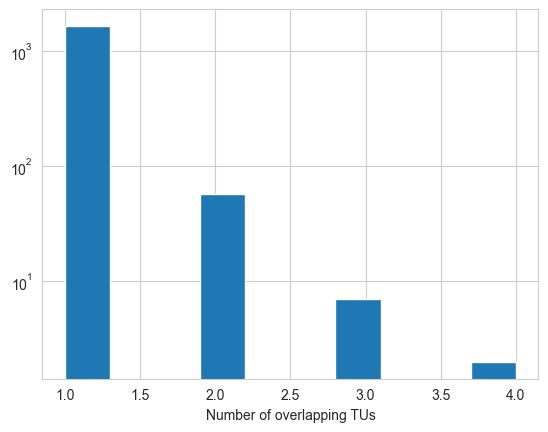

In [53]:
# If TUs have overlapping TSSs, link all the TUs to the same promoter and add terminators in their place
# Identify sets of TUs with same TSS
# NOTE: When I ran this code on all the TUs, I got one set with 700 indices 
# that I think corresponds to nan entries
grouped_tus = nan_70_tus.groupby(['strand', 'tss', 'sigma_factor']) 
tss_sets = [set(indices) for indices in grouped_tus.groups.values()]
tss_sets_len = [len(tss_set) for tss_set in tss_sets]

fig, ax = plt.subplots()
ax.hist(tss_sets_len)
ax.set_yscale('log')
ax.set_xlabel('Number of overlapping TUs')

In [54]:
# Create a dictionary linking each TU to the set of genes with definite expression
tu_gene_dict = {}

for TU in nan_70_tus.index:
    gene_set = set(mg1655._tu_to_genes[TU]).intersection(definite_expression.index)
    tu_gene_dict[str(TU)] = gene_set

# Create a dictionary linking each TU to a TSS/promoter
# Each TU has only one promoter, but each promoter can have multiple TUs
tu_promoter_dict = {}
for tss_set in tss_sets:
    for TU in tss_set:
        tu_promoter_dict[str(TU)] = 'p_'+str(int(mg1655.tu_table.loc[TU, 'tss'])).zfill(7)

# Keep track of the inverse mapping as well
promoter_table = pd.DataFrame(columns = nan_70_tus.columns)

promoter_tu_dict = {}
for TU, promoter in tu_promoter_dict.items():
    if promoter_tu_dict.get(promoter) is None:
        promoter_tu_dict[promoter] = {TU}
        promoter_table.loc[promoter, :] = nan_70_tus.loc[TU, :].copy().to_list()
    else:
        promoter_tu_dict[promoter] = promoter_tu_dict[promoter].union({TU})

# Create a dictionary linking each promoter to a set of genes
promoter_gene_dict = {}
for promoter in promoter_tu_dict.keys():
    promoter_gene_dict[promoter] = set()
    for TU in promoter_tu_dict[promoter]:
        promoter_gene_dict[promoter] = promoter_gene_dict[promoter].union(tu_gene_dict[TU])

promoter_table

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
p_0021120,rpsT,-1.0,21120.0,Sigma70,21125.0,21131.0,21148.0,21154.0,20771.0,21120.0,349.0
p_0021210,rpsT,-1.0,21210.0,Sigma70,21215.0,21221.0,21234.0,21240.0,20771.0,21210.0,439.0
p_0042037,caiTABCDE,-1.0,42037.0,Sigma70,42044.0,42049.0,42071.0,42076.0,34781.0,42037.0,7256.0
p_0052034,apaGH,-1.0,52034.0,Sigma70,52040.0,52046.0,52061.0,52067.0,50380.0,52034.0,1654.0
p_0052588,rsmA-apaGH,-1.0,52588.0,Sigma70,52593.0,52599.0,52621.0,52627.0,50380.0,52588.0,2208.0
...,...,...,...,...,...,...,...,...,...,...,...
p_4619567,deoBD,1.0,4619567.0,Sigma70,4619555.0,4619560.0,NaN,NaN,4619567.0,4621659.0,2092.0
p_4624856,serB-radA,1.0,4624856.0,Sigma70,4624845.0,4624851.0,4624821.0,4624827.0,4624856.0,4627294.0,2438.0
p_4632704,trpR,1.0,4632704.0,Sigma70,4632691.0,4632696.0,4632664.0,4632669.0,4632704.0,4633144.0,440.0
p_4635477,creABCD,1.0,4635477.0,Sigma70,4635464.0,4635469.0,4635442.0,4635447.0,4635477.0,4639572.0,4095.0


In [55]:
#Create various dataframes
terminator_table = pd.DataFrame(columns = ['strand', 'position'])

promoter_list = []
terminator_set = set()
for promoter in tu_promoter_dict.values():
    if promoter not in promoter_list:
        promoter_list.append(promoter) 

# Create a dictionary to store mapping between promoters and terminators
promoter_terminator_dict = {}

# Create separate DataFrames since we only predict using promoters
gene_promoter = pd.DataFrame(data = 0.0, index = definite_expression.index, columns = promoter_list)
one_hot_promoters = pd.DataFrame(data = 0, index = promoter_list, columns = one_hot_tus.columns)
gene_terminator = pd.DataFrame(index = definite_expression.index)

# Update the gene_promoter, one_hot_promoters, and gene_terminator DataFrames
for promoter in gene_promoter.columns:
    gene_promoter.loc[list(promoter_gene_dict[promoter]), promoter] = 1.0
    # NOTE: I don't understand why, but I ran into a value error concerning the shape of the one_hot_tus data
    one_hot_promoters.loc[promoter, :] = one_hot_tus.loc[list(promoter_tu_dict[promoter])[0], :].copy().to_list()

    # Determine the set of TUs that correspond to the current promoter
    current_tus = list(promoter_tu_dict[promoter])
    # If there are multiple, overlapping TUs, introduce a terminator
    if len(current_tus) > 1:
        # Exclude the last TU since that corresponds to the promoter when we sort by length
        for i, TU in enumerate(nan_70_tus.loc[current_tus, :].sort_values(by = 'length', ascending = True).index[0:-1]):
            # Use the end of the TU as the terminator position
            if nan_70_tus.loc[TU, 'strand'] > 0:
                terminator = 't_'+str(int(nan_70_tus.loc[TU, 'right'])).zfill(7)
                terminator_table.loc[terminator, 'position'] = nan_70_tus.loc[TU, 'right']
            else:
                terminator = 't_'+str(int(nan_70_tus.loc[TU, 'left'])).zfill(7)
                terminator_table.loc[terminator, 'position'] = nan_70_tus.loc[TU, 'left']

            # Take the difference between the largest and current TUs genes to get the set affected by the terminator
            terminator_genes = promoter_gene_dict[promoter].difference(tu_gene_dict[TU])

            # Update the gene_terminator DataFrame with zeroes everywhere else
            gene_terminator.loc[:, terminator] = 0.0
            gene_terminator.loc[list(terminator_genes), terminator] = 1.0

            # Update the Terminator-Table with the approximate terminator position
            # NOTE: If the terminator is a duplicate it is overwritten, I'm not sure if there are any terminators that act in both forward and reverse orientations
            terminator_table.loc[terminator, 'strand'] = nan_70_tus.loc[TU, 'strand']
            
            # promoter_terminator dict
            if promoter_terminator_dict.get(promoter) is None:
                promoter_terminator_dict[promoter] = {terminator}
            else:
                promoter_terminator_dict[promoter] = promoter_terminator_dict[promoter].union({terminator})

            terminator_set.add(terminator)

terminator_list = list(terminator_set)

In [56]:
#Set up promoter and terminator clusters
gene_tu = pd.DataFrame(data = 0.0, index = definite_expression.index, columns = nan_70_tus.index)

for gene in gene_tu.index:
    # Only include TUs that belong to the columns of gene_tu
    tu_list = set(mg1655._gene_to_tus[gene]).intersection(gene_tu.columns)
    
    for tu in tu_list:
        gene_tu.loc[gene, tu] = 1.0

# Drop columns from the DataFrame if no genes are recorded as in the TU
gene_tu = gene_tu[gene_tu.columns[gene_tu.sum() > 0.0]]

# NOTE: Move this code snippet to where it is needed
# Drop rows from the DataFrame if no genes have associated TUs
gene_tu = gene_tu.loc[[gene for gene in gene_tu.index if gene_tu.loc[gene, :].sum() > 0.0], :]

gene_tu

,ECK120008913,ECK120008916,ECK120008917,ECK120008918,ECK120008919,ECK120008921,ECK120008922,ECK120008923,ECK120008924,ECK120008925,...,ECK125165382,ECK125165383,ECK125165386,ECK125165387,ECK125165941,ECK125203408,ECK125286549,ECK125286557,ECK125286563,ECK125336161
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b4398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b4399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
# Code is from tu_survey.ipynb, modified to be limited to the genes in gene_tu
tu_set_list = [] # List of sets of non-overlapping TUs

# Get the set of TUs that are the columns of gene_tu, and limit the clusters 
# to only include these
all_tus = set(gene_tu.columns)

for TU in gene_tu.columns:
    # List of genes in each TU
    genes_in_tu = gene_tu.loc[gene_tu.loc[:,TU] == 1].index.tolist()

    # Find set of TUs with common genes for current TUs
    common_tu = set()
    for gene in genes_in_tu:
        if gene in mg1655._gene_to_tus:
            # Only use TUs that are in the columns of gene_tu
            valid_tus = [tu for tu in mg1655._gene_to_tus[gene] if tu in all_tus]
            common_tu.update(valid_tus) # List of TUs for each gene

    # Check if this set of TUs overlaps with any previous set
    overlap = False
    for i, tu_set in enumerate(tu_set_list):
        # If there is at least one common element between two sets, combine them
        if common_tu.intersection(tu_set):
            # Update the previous set (Caught six TUs this way!)
            tu_set_list[i] = tu_set.union(common_tu)
            overlap = True
            break

    if overlap == False:
        tu_set_list.append(common_tu)

# Remove any empty sets that may have made it through
tu_set_list = [tu_set for tu_set in tu_set_list if tu_set != set()]

# Calculate the length of each TU set
tu_set_lengths = [len(tu_set) for tu_set in tu_set_list]

In [58]:
promoter_list_list = []
promoter_terminator_list_list = []

# I am including terminators here to make it easier to create the train/lockbox sets
for tu_set in tu_set_list:
    promoter_set = set()
    terminator_set = set()
    for TU in tu_set:
        promoter_set = promoter_set.union({tu_promoter_dict[TU]})
        terminator_set = terminator_set.union({tu_promoter_dict[TU]})
    
    # Only include promoters that have a one-hot encoding
    promoter_set = promoter_set.intersection(set(one_hot_promoters.index))

    for promoter in promoter_set:
        if promoter_terminator_dict.get(promoter) is None:
            continue
        else:
            terminator_set = terminator_set.union(promoter_terminator_dict[promoter])
    
    promoter_list = list(promoter_set)
    promoter_list.sort()
    promoter_list_list.append(promoter_list)

    terminator_list = list(terminator_set)
    terminator_list.sort()
    promoter_terminator_list_list.append(terminator_list)

promoter_list_lengths = [len(promoter_list) for promoter_list in promoter_list_list]
promoter_terminator_list_lengths = [len(_list) for _list in promoter_terminator_list_list]

In [59]:
# Setup Train/Test/Lockbox sets
# Determine the size of the lockbox
# NOTE: As an "easy" way to cut down the samples to get a toy model, I've set lockbox to half the data
lockbox_size = int(len(promoter_list_lengths) * 0.50)

# Determine the indices of the lockbox and train/test sets
promoter_list_length_one = np.where(np.array(promoter_terminator_list_lengths) == 1)[0]

lockbox_indices = sorted(rng.choice(a = promoter_list_length_one,
                                    size = lockbox_size,
                                    replace = False))

# Split the promoter clusters
train_test_lists = [promoter_list_list[i] for i in range(len(promoter_list_list)) if i not in lockbox_indices]
train_test_list_lengths = [len(promoter_list) for promoter_list in train_test_lists]
lockbox_lists = [promoter_list_list[i] for i in lockbox_indices]

# Create a copy of gene_promoter that only contains the train_test_lists promoters
train_promoters = [promoter for promoter_list in train_test_lists for promoter in promoter_list]
train_promoters.sort()
gene_promoter_train = gene_promoter.copy(deep = True)
gene_promoter_train = gene_promoter_train.loc[:, train_promoters]

# Drop genes with no corresponding TUs listed to decrease matrix size
train_genes = [gene for gene in gene_promoter_train.index if gene_promoter_train.loc[gene, :].sum() != 0]
train_genes.sort()
gene_promoter_train = gene_promoter_train.loc[train_genes, :]

# Update the b vector so that it has the same genes
tpm_train = 2**mg1655.gene_table.loc[gene_promoter_train.index, condition_of_interest]

# Update the gene_terminator DataFrame as well
gene_terminator_train = gene_terminator.copy(deep = True)
gene_terminator_train = gene_terminator_train.loc[train_genes, :]

# Do the same for the lockbox set
lockbox_promoters = [promoter for promoter_list in lockbox_lists for promoter in promoter_list]
lockbox_promoters.sort()
gene_promoter_lockbox = gene_promoter.copy(deep = True)
gene_promoter_lockbox = gene_promoter_lockbox.loc[:, lockbox_promoters]
lockbox_genes = [gene for gene in gene_promoter_lockbox.index if gene_promoter_lockbox.loc[gene, :].sum() != 0]
lockbox_genes.sort()
gene_promoter_lockbox = gene_promoter_lockbox.loc[lockbox_genes, :]
tpm_lockbox = 2**mg1655.gene_table.loc[gene_promoter_lockbox.index, condition_of_interest]

In [60]:
# Generate the structure of 1-promoter clusters and their median gene expression
promoter_1cluster_lists = [promoter_list_list[i] for i in promoter_list_length_one]

promoter_1cluster_promoters = [promoter for promoter_list in promoter_1cluster_lists for promoter in promoter_list]
promoter_1cluster_promoters.sort()
gene_promoter_1cluster = gene_promoter.copy(deep = True)
gene_promoter_1cluster = gene_promoter_1cluster.loc[:, promoter_1cluster_promoters]
promoter_1cluster_genes = [gene for gene in gene_promoter_1cluster.index if gene_promoter_1cluster.loc[gene, :].sum() != 0]
promoter_1cluster_genes.sort()
gene_promoter_1cluster = gene_promoter_1cluster.loc[promoter_1cluster_genes, :]
tpm_1cluster = 2**mg1655.gene_table.loc[gene_promoter_1cluster.index, condition_of_interest]

In [61]:
# Solve using the median gene expression as the initial value
promoter_1cluster_target = pd.DataFrame(index = gene_promoter_1cluster.columns)
for indice in promoter_1cluster_target.index:
    genes = gene_promoter[gene_promoter.loc[:, indice] == 1].index.to_list()
    #print(genes)
    promoter_1cluster_target.loc[indice, 0] = tpm_1cluster.loc[genes].median()

#The resulting promoter set for safe testing therefore is:
#gene_promoter_1cluster
#promoter_1cluster_target

In [62]:
gene_promoter_1cluster.head()

,p_0008191,p_0017458,p_0034218,p_0042037,p_0042325,p_0049799,p_0065803,p_0070075,p_0070223,p_0077338,...,p_4603034,p_4603319,p_4605777,p_4607781,p_4609358,p_4611153,p_4624799,p_4624856,p_4632704,p_4635353
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0008,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0019,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0020,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0034,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b0035,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
promoter_1cluster_target.head()

,0
p_0008191,1644.706773
p_0017458,54.105023
p_0034218,7.326374
p_0042037,5.293768
p_0042325,2.156789


In [64]:
#Spot check the outcome
cur_prom = 'p_0008191'
print(promoter_table.loc[cur_prom])
cur_row = definite_expression.loc[definite_expression['name'] == promoter_table.loc[cur_prom]['name']]
#cur_tpm = cur_row['log_tpm'].values[0]
cur_tpm = cur_row['log_tpm_basal'].values[0]
np.power(2,cur_tpm)

name              talB
strand             1.0
tss             8191.0
sigma_factor       NaN
box_10_left        NaN
box_10_right       NaN
box_35_left        NaN
box_35_right       NaN
left            8191.0
right           9226.0
length          1035.0
Name: p_0008191, dtype: object


1644.7067726971325

In [65]:
#Can't resolve promoters with multiple genes
cur_prom = 'p_0017458'
print(promoter_table.loc[cur_prom])
cur_row = definite_expression.loc[definite_expression['name'] == promoter_table.loc[cur_prom]['name']]
#cur_tpm = cur_row['log_tpm'].values[0]
cur_tpm = cur_row['log_tpm_basal'].values[0]
np.power(2,cur_tpm)

name              nhaAR
strand              1.0
tss             17458.0
sigma_factor    Sigma70
box_10_left     17445.0
box_10_right    17450.0
box_35_left     17424.0
box_35_right    17429.0
left            17458.0
right           19620.0
length           2162.0
Name: p_0017458, dtype: object


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
#Just look up those by name
cur_row = definite_expression.loc[definite_expression['name'] == 'nhaA']
#cur_tpm = cur_row['log_tpm'].values[0]
cur_tpm = cur_row['log_tpm_basal'].values[0]
print(np.power(2,cur_tpm))

cur_row = definite_expression.loc[definite_expression['name'] == 'nhaR']
#cur_tpm = cur_row['log_tpm'].values[0]
cur_tpm = cur_row['log_tpm_basal'].values[0]
print(np.power(2,cur_tpm))

## New promoter handling - both native and synthetic

In [72]:
def motif_search(search_sequence: str, left: int, right: int, strand: int, motif_pssm: Dict[str, List[float]],
                        n_best_matches: int = 1) -> pd.DataFrame:
        
        """
        Given a sequence range to explore and a motif PSM to find, return statistics about the
        closest-matching subsequence within the given range, as a dict. None will be returned if no
        sufficiently-strong match is found.

        :param int left: the left end of the sequence range to search
        :param int right: the right end of the sequence range to search
        :param int strand: the strand of the sequence range to search
        :param Dict[str, List[float]] motif_pssm: the position-specific scoring matrix (PSSM)
            describing the motif to look for in the provided range
        :param int n_best_matches: the number of matched sequences to return; defaults to 1
        :return pd.DataFrame result_table: a DataFrame of results, with columns: match_sequence,
            log_odds, left, and right; left and right are in terms of the reference genome;
            number of rows is determined by n_best_matches
        """
            
        motif_length = len(motif_pssm['A'])
        
        motif_pssm = matrix.PositionSpecificScoringMatrix(motif_pssm.keys(), motif_pssm)

        cur_seq_search = search_sequence[left:right]
    
        cur_score = motif_pssm.calculate(cur_seq_search) #Will only return a single value
            

        result_table = pd.DataFrame(columns=['match_sequence', 'log_odds', 'left', 'right'])

        '''
        best_matches_idx = (-scores).argsort()[:n_best_matches]

        for start_ind in best_matches_idx:
            # get the left/right ends of the sequence; note that the best_start_ind is w.r.t. the
            # SEQUENCE, which is in CODING order; so it's distance from the START of the sequence
            if strand == 1:
                best_left, best_right = left + start_ind, left + start_ind + motif_length - 1
            else:
                best_right, best_left = right - start_ind, right - start_ind - motif_length + 1
            
            #sub_sequence_best = self.get_sequence(best_left, best_right, strand)
            sub_sequence_best = search_sequence[best_left:best_right]
        '''
        result_table = pd.concat([result_table, pd.DataFrame({'match_sequence': str(cur_seq_search),
                                            'log_odds': cur_score,
                                            'left': left, 'right': right}, index=[0])],
                                            ignore_index=True)

        return result_table

In [73]:
df_prom_generic = pd.DataFrame(columns=['Name','Expression','Sequence','Genome_Loc','Strand','Genes','N_Proms_in_TU','TSS_annotated','M10U_annotated','M35U_annotated'])

In [74]:
#Urtecho 2019 info

loc_tss_urt2019 = 120
loc_m10U_urt2019 = 108
loc_m35U_urt2019 = 85
loc_integration_urt2019 = 1712671 #Location of ydgR/dtpA

df_prom_generic['Name'] = data_urtecho2019.index
df_prom_generic = df_prom_generic.set_index('Name')
df_prom_generic['Sequence'] = data_urtecho2019['Full Promoters']
df_prom_generic['Expression'] = data_urtecho2019['Expr']
df_prom_generic['Genome_Loc'] = loc_integration_urt2019
df_prom_generic['Strand'] = 1
df_prom_generic['Genes'] = "RiboJ+sfGFP"
df_prom_generic['N_Proms_in_TU'] = 1
df_prom_generic['TSS_annotated'] = loc_tss_urt2019
df_prom_generic['M10U_annotated'] = loc_m10U_urt2019
df_prom_generic['M35U_annotated'] = loc_m35U_urt2019

df_prom_generic.head()

,Expression,Sequence,Genome_Loc,Strand,Genes,N_Proms_in_TU,TSS_annotated,M10U_annotated,M35U_annotated
Name,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0.056887,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,1712671,1,RiboJ+sfGFP,1,120,108,85
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0.057433,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,1712671,1,RiboJ+sfGFP,1,120,108,85
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0.067989,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,1712671,1,RiboJ+sfGFP,1,120,108,85
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0.075731,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,1712671,1,RiboJ+sfGFP,1,120,108,85
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0.077008,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,1712671,1,RiboJ+sfGFP,1,120,108,85


In [75]:
#Verifying that these indices work as intended
df_prom_generic['Sequence'].iloc[0][loc_m10U_urt2019:(loc_m10U_urt2019+6)]

'GTTGTA'

In [76]:
data_urtecho2019.head()

,Expr,Full Promoters,Background_Up,UP,Buffer_UP,m35,Spacer,m10,Buffer_TSS,TSS,Background_Down
Names,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0.056887,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGGATGTCGCTCGCGAACTATT,GCG,TTGACA,CTTTATGCTTCGGCTCG,GTTGTA,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0.057433,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGAAAATTTTTTTTCAAAAGTA,GCG,ATTACA,TCGCGCATGATCGAAAG,GATAAC,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0.067989,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGAAAATTTTTTTTCAAAAGTA,GCG,TTTACC,AAAACTCATTTTATTTT,GATAAC,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0.075731,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GAAAATATATTTTTCAAAAGTA,GCG,TTAAGA,TTTCCATTAGCGAGTAT,GTTAAA,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0.077008,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,GCGCAAGCGTCGCATCAGGCAG,TCG,TTTACA,CTTTATGCTTCGGCTCG,GATAAC,TTATCC,A,GCCTACGGAGGGTGCGGGAATTTGTAGGC


In [77]:
# Write a better promoter sweeper
#'M10U_auto','M35U_auto'

#For each index, examine spacer lengths 14-20, and sum the m10 and m35 log odds, keep the best and its spacer length
min_spacer = 15
max_spacer = 19
cur_seq = df_prom_generic['Sequence'].iloc[0]
cur_len_seq = len(cur_seq)
cur_len_boxes = 12
print(cur_seq)

pssm_m10 = pd.DataFrame(M_prib['Sigma70']);
pssm_m35 = pd.DataFrame(M_m35['Sigma70']);
cur_strand = 1

range_spacer = range(min_spacer,max_spacer+1)

cur_scores = []
len_spacers = []
for cur_ind in range(cur_len_seq):
    cur_scores_spacersweep = []
    for cur_len_spacer in range_spacer:
        cur_left = cur_len_seq-cur_ind-cur_len_boxes-cur_len_spacer
        cur_right = cur_len_seq-cur_ind
        if cur_left>=0:
            cur_subseq = cur_seq[cur_left:cur_right]
            #print(cur_subseq) #Verify that the left and right side of the full sequence are printed
            
            cur_left_m10 = len(cur_subseq)-6
            cur_right_m10 = len(cur_subseq)+1
            cur_result_table_m10 = motif_search(cur_subseq,left=cur_left_m10, right=cur_right_m10, strand=cur_strand, motif_pssm=pssm_m10, n_best_matches=1)
            cur_value_m10 = cur_result_table_m10['log_odds'].to_list()

            cur_left_m35 = len(cur_subseq)-cur_len_spacer-12
            cur_right_m35 = len(cur_subseq)-cur_len_spacer-6
            cur_result_table_m35 = motif_search(cur_subseq,left=cur_left_m35, right=cur_right_m35, strand=cur_strand, motif_pssm=pssm_m35, n_best_matches=1)
            cur_value_m35 = cur_result_table_m35['log_odds'].to_list()
            
            cur_score_swept = cur_value_m10[0]+cur_value_m35[0]
            
            cur_scores_spacersweep.append(cur_score_swept)

    if cur_scores_spacersweep:
        cur_max_value = max(cur_scores_spacersweep)
        cur_max_index = cur_scores_spacersweep.index(cur_max_value)
        cur_max_spacer = range_spacer[cur_max_index]
        cur_scores.append(cur_max_value)
        len_spacers.append(cur_max_spacer)
    

TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGCGCGTAACGAGGCGTGGGATGTCGCTCGCGAACTATTGCGTTGACACTTTATGCTTCGGCTCGGTTGTAAGCAGGATCAGCCGCTGCGGATGCGATTAAGCGAAC


In [78]:
cur_subseq = 'TTGAGCAGGCTTATCAGCTGGTGGTGGCA'
#cur_subseq = 'TCAGCCGCTGCGGATGCGATTAAGCGAAC'

print(len(cur_subseq))

cur_len_spacer = 17

cur_left_m10 = len(cur_subseq)-6
cur_right_m10 = len(cur_subseq)+1
cur_result_table_m10 = motif_search(cur_subseq,left=cur_left_m10, right=cur_right_m10, strand=cur_strand, motif_pssm=pssm_m10, n_best_matches=1)
cur_value_m10 = cur_result_table_m10['log_odds'].to_list()
print(cur_result_table_m10)

cur_left_m35 = len(cur_subseq)-cur_len_spacer-12
cur_right_m35 = len(cur_subseq)-cur_len_spacer-6
cur_result_table_m35 = motif_search(cur_subseq,left=cur_left_m35, right=cur_right_m35, strand=cur_strand, motif_pssm=pssm_m35, n_best_matches=1)
cur_value_m35 = cur_result_table_m35['log_odds'].to_list()

print(cur_result_table_m35)

cur_score_swept = cur_value_m10[0]+cur_value_m35[0]

29
  match_sequence   log_odds left right
0         GTGGCA -15.485041   23    30
  match_sequence  log_odds left right
0         TTGAGC -6.467363    0     6


In [79]:
cur_pssm = pssm_m35
print(cur_pssm)
motif_pssm = matrix.PositionSpecificScoringMatrix(cur_pssm.keys(), cur_pssm)
    
cur_score = motif_pssm.calculate('TTGAGC')
print(cur_score)

          A         C         G         T
0 -2.255761 -2.730029 -3.188138 -0.237318
1 -4.658990 -6.105909 -3.642055 -0.038641
2 -2.032618 -2.159484 -0.473801 -2.032618
3 -0.727164 -1.240299 -2.386258 -1.999142
4 -1.038578 -1.038578 -2.680019 -1.498242
5 -0.838051 -2.310419 -1.893781 -1.146567
-6.467363


(array([ 2.,  6.,  2.,  5., 12.,  8.,  5., 12.,  7., 11., 13.,  8.,  5.,
        11.,  1.,  5.,  1.,  2.,  2.,  6.]),
 array([-29.98836613, -29.21601145, -28.44365678, -27.6713021 ,
        -26.89894743, -26.12659276, -25.35423808, -24.58188341,
        -23.80952873, -23.03717406, -22.26481938, -21.49246471,
        -20.72011003, -19.94775536, -19.17540069, -18.40304601,
        -17.63069134, -16.85833666, -16.08598199, -15.31362731,
        -14.54127264]),
 <BarContainer object of 20 artists>)

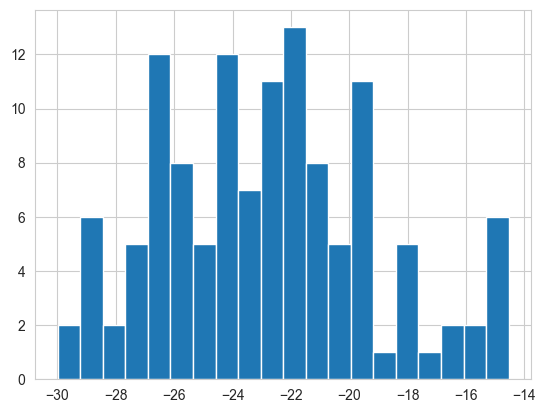

In [80]:
#Plot the histogram of the results for all indices and look for clear outliers, with preference for spacers ~17

plt.hist(cur_scores, 20)

-14.541272640228271
67
17


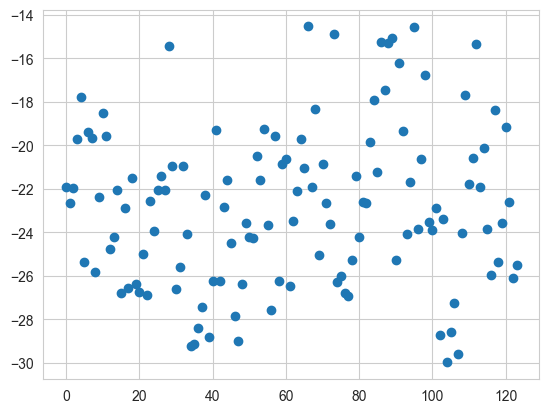

In [81]:

inds_seq = list(reversed(range(len(cur_scores))))

max_value = max(cur_scores)
max_index = cur_scores.index(max_value)
print(max_value)
print(len(cur_scores)-max_index)
print(len_spacers[29])

plt.scatter(inds_seq,cur_scores)

In [82]:
data_urtecho2023.head()

,sequence,tss_position,strand,activity,category,Full length,Upstream,TSS,Downstream
name,,,,,,,,,
TSS_1_storz_regulondb,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,38,+,2.769229,active,150,AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...,T,CACTAAATACTTTAACCAATATAGGCATA
TSS_3_storz,TTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGC...,122,-,0.010156,inactive,150,TTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGC...,G,ACCTAAGTCAATAAAATTTTAATTTACTC
TSS_4_wanner,ATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTC...,147,+,2.327789,active,150,ATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTC...,A,TAGCGCACAGACAGATAAAAATTACAGAG
TSS_5_storz,AGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCAT...,412,+,0.224347,inactive,150,AGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCAT...,G,CAATGCCAGGCAGGGGCAGGTGGCCACCG
TSS_6_regulondb,GGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAA...,683,+,0.023604,inactive,150,GGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAA...,T,AGCATCAACGCTGCGCTGATTTGCCGTGG


In [83]:
tu_set_list 

[{'ECK120008913'},
 {'ECK120008916'},
 {'ECK120008917'},
 {'ECK120008918', 'ECK120008919'},
 {'ECK120008921', 'ECK120009212', 'ECK125286569'},
 {'ECK120008922', 'ECK120009488', 'ECK120015178'},
 {'ECK120008923', 'ECK120008924'},
 {'ECK120008925', 'ECK125165934'},
 {'ECK120008938',
  'ECK120008939',
  'ECK120008940',
  'ECK120008941',
  'ECK120009449',
  'ECK120009800',
  'ECK120011082',
  'ECK120011083'},
 {'ECK120008942'},
 {'ECK120008944', 'ECK120009440'},
 {'ECK120008945', 'ECK120008946', 'ECK120008947', 'ECK120009313'},
 {'ECK120008948'},
 {'ECK120008949',
  'ECK120009189',
  'ECK120009401',
  'ECK120011112',
  'ECK120011113',
  'ECK120011114',
  'ECK120026526',
  'ECK120033221',
  'ECK120033235',
  'ECK120033236',
  'ECK120034115'},
 {'ECK120008951'},
 {'ECK120008953', 'ECK125162169'},
 {'ECK120008954'},
 {'ECK120008956', 'ECK120008957'},
 {'ECK120008958'},
 {'ECK120008959'},
 {'ECK120008960'},
 {'ECK120008961'},
 {'ECK120008962'},
 {'ECK120008963'},
 {'ECK120008964'},
 {'ECK12000

In [84]:
promoter_list_list

[['p_1832013'],
 ['p_2800656'],
 ['p_4105785'],
 ['p_4042391', 'p_4043377'],
 ['p_0940823', 'p_0940878', 'p_0943957'],
 ['p_0816827', 'p_0816914', 'p_0817977'],
 ['p_1157626', 'p_1157766'],
 ['p_2716506', 'p_2716523'],
 ['p_3881841',
  'p_3881861',
  'p_3882348',
  'p_3882562',
  'p_3882590',
  'p_3882733',
  'p_3883882',
  'p_3883961'],
 ['p_1842308'],
 ['p_4448402', 'p_4448428'],
 ['p_0710716', 'p_0710723', 'p_0710829', 'p_0711521'],
 ['p_2060941'],
 ['p_0089596',
  'p_0090010',
  'p_0090688',
  'p_0091012',
  'p_0102867',
  'p_0103561',
  'p_0104636',
  'p_0104693',
  'p_0105045',
  'p_0106508',
  'p_0106530'],
 ['p_3683498'],
 ['p_3373620'],
 ['p_1671327'],
 ['p_1257882', 'p_1258542'],
 ['p_0595573'],
 ['p_0595462'],
 ['p_2662199'],
 ['p_2791172'],
 ['p_3128076'],
 ['p_3128206'],
 ['p_4611153'],
 ['p_1007672'],
 ['p_0141263', 'p_0141279'],
 ['p_0890892', 'p_0891876'],
 ['p_0222714'],
 ['p_3058456', 'p_3058549'],
 ['p_0368519'],
 ['p_4467271', 'p_4467275', 'p_4467279', 'p_4467347'],

In [85]:
promoter_table

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
p_0021120,rpsT,-1.0,21120.0,Sigma70,21125.0,21131.0,21148.0,21154.0,20771.0,21120.0,349.0
p_0021210,rpsT,-1.0,21210.0,Sigma70,21215.0,21221.0,21234.0,21240.0,20771.0,21210.0,439.0
p_0042037,caiTABCDE,-1.0,42037.0,Sigma70,42044.0,42049.0,42071.0,42076.0,34781.0,42037.0,7256.0
p_0052034,apaGH,-1.0,52034.0,Sigma70,52040.0,52046.0,52061.0,52067.0,50380.0,52034.0,1654.0
p_0052588,rsmA-apaGH,-1.0,52588.0,Sigma70,52593.0,52599.0,52621.0,52627.0,50380.0,52588.0,2208.0
...,...,...,...,...,...,...,...,...,...,...,...
p_4619567,deoBD,1.0,4619567.0,Sigma70,4619555.0,4619560.0,NaN,NaN,4619567.0,4621659.0,2092.0
p_4624856,serB-radA,1.0,4624856.0,Sigma70,4624845.0,4624851.0,4624821.0,4624827.0,4624856.0,4627294.0,2438.0
p_4632704,trpR,1.0,4632704.0,Sigma70,4632691.0,4632696.0,4632664.0,4632669.0,4632704.0,4633144.0,440.0
p_4635477,creABCD,1.0,4635477.0,Sigma70,4635464.0,4635469.0,4635442.0,4635447.0,4635477.0,4639572.0,4095.0


In [38]:
#Display the lack of agreement of background regions (probably does not matter)
mg1655.get_sequence(2945404,2945554,1)

Seq('TTTTATTGCGCCGACAATAAGCAATCAGCGCCGCTTTGGGCCGTACACTATCAA...GTT', IUPACAmbiguousDNA())

In [ ]:
#AAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTA

In [42]:
mg1655.get_sequence(103,203,1)

Seq('AAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCAC...TAG', IUPACAmbiguousDNA())

In [45]:
#113 location + strand
#AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATT
#AAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATA
mg1655.get_sequence(103,203,1)

Seq('AAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCAC...TAG', IUPACAmbiguousDNA())

In [48]:
mg1655.get_sequence(112,116,1)

Seq('TGACT', IUPACAmbiguousDNA())

In [44]:
#122 location, - strand
#TTACCTGTGGTAATGGTGATGGTGGTGGTAATGGTGGTGCTAATGCGTTTCATGGATGTTGTGTACTCTGTAATTTTTATCTGTCTG
#TGCGCTATGCCTATATTGGTTAAAGTATTTAGTGACCTAAGTCAATAAAATTTTAATTTACTC
mg1655.get_sequence(5,155,-1)

Seq('TGCGCTATGCCTATATTGGTTAAAGTATTTAGTGACCTAAGTCAATAAAATTTT...AAA', IUPACAmbiguousDNA())

In [61]:
mg1655.sequence.find("CTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATT")

2

In [59]:
len(mg1655.sequence)-mg1655.sequence.reverse_complement().find("TGCGCTATGCCTATATTGGTTAAAGTATTTAGTGACCTAAGTCAATAAAATTTTAATTTACTC")

155

In [ ]:
m10_result = self.motif_search(m10_left, m10_right, strand, minus_10_motif).iloc[0, :]
m35_result = self.motif_search(m35_left, m35_right, strand, minus_35_motif).iloc[0, :]

# get the locations of the boxes in terms relative to the TSS
m10_point = location_to_point(m10_result['left'], m10_result['right'], strand, 'midpoint')
m10_location = -abs(tss - m10_point)
m35_point = location_to_point(m35_result['left'], m35_result['right'], strand, 'midpoint')
m35_location = -abs(tss - m35_point)

# compute some properties of the spacer between the -10 and -35 elements
if strand == 1:
    spacer_left, spacer_right = m35_result['right'], m10_result['left']
else:
    spacer_left, spacer_right = m10_result['right'], m35_result['left']
    spacer_sequence = self.get_sequence(spacer_left, spacer_right, strand)
    spacer_at = 1 - GC(spacer_sequence) / 100

In [145]:
a=[]
spacer_max = 23
spacer_min = 12
for i,j,k in zip(tu_table['sigma_factor'], tu_table['strand'], tu_table['tss']):
    if not isinstance(i, str):
        if k.is_integer():
            if j == 1:
                #print(k)
                m_10_left = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) -3
                m_10_right = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) +3
                m_35_left = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) -3
                m_35_right = (k + int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) +3
                #spacer length < 23
                if (-m_35_right + m_10_left) < 23:
                    a.append(['Sigma70', k, m_10_left, m_10_right, m_35_left, m_35_right])
            if j == -1:
                m_10_left = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) -3
                m_10_right = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m10_location'])) +3
                m_35_left = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) -3
                m_35_right = (k - int(mg1655.featurize_promoter(k, j, minus_10_motif=M_prib_sigma70, minus_35_motif=M_m35_sigma70,
                                 usr=(-65, -45))['m35_location'])) +3
                #12 < spacer length < 23
                if ((-m_10_right + m_35_left)) < spacer_max and ((-m_10_right + m_35_left)) > spacer_min:
                    a.append(['Sigma70', k, m_10_left, m_10_right, m_35_left, m_35_right])
            
print(len(a))

453


In [146]:
update_columns = ['sigma_factor', 'tss', 'box_10_left', 'box_10_right','box_35_left', 'box_35_right']

for sublist in a:
    match_value = sublist[1]
    matching_index = tu_table[tu_table['tss'] == match_value].index
    if not matching_index.empty:
        tu_table.loc[matching_index, update_columns] = sublist[0:len(update_columns)]

#tu_table = tu_table.set_index('locus_tag')
tu_table
#tu_table.to_csv('tu_table_updated.csv')

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right
locus_tag,,,,,,,,,,
ECK120008913,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0
ECK120008914,astCADBE,-1.0,1832044.0,Sigma54,1832054.0,1832058.0,1832065.0,1832070.0,1825955.0,1832044.0
ECK120008915,astCADBE,-1.0,1832039.0,Sigma38,1832046.0,1832056.0,1832070.0,1832075.0,1825955.0,1832039.0
ECK120008916,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0
ECK120008917,cpxPQ,1.0,4105785.0,Sigma70,4105772.0,4105777.0,4105746.0,4105751.0,4105785.0,4106379.0
...,...,...,...,...,...,...,...,...,...,...
ECK125302596,hemF,1.0,2552982.0,Sigma70,2552972.0,2552978.0,2552944.0,2552950.0,2552982.0,2554124.0
ECK125302597,tnaAB,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3888730.0,3891483.0
ECK125328143,aspXS,-1.0,4366951.0,Sigma70,4366957.0,4366963.0,4366980.0,4366986.0,4366839.0,4366951.0


# Data Inspection/Frequency distributions

In [32]:
tss_box_10 =[]
box_10_len = []
spacer = []
box_35_len = []

for index, row in tu_table.iterrows():
    tss, box_10_left, box_10_right, box_35_left, box_35_right, strand = row['tss'], row['box_10_left'], row['box_10_right'], row['box_35_left'], row['box_35_right'], row['strand']

    if strand == 1:
        
        tss_box_10.append(tss - box_10_right)
        box_10_len.append(box_10_right - box_10_left)
        spacer.append(-box_35_right + box_10_left)
        box_35_len.append(box_35_right - box_35_left)
        
    elif strand == -1:
        
        tss_box_10.append(box_10_left - tss)
        box_10_len.append(box_10_right - box_10_left)
        spacer.append(box_35_left - box_10_right)
        box_35_len.append(box_35_right - box_35_left)
        
    else:
        
        tss_box_10.append(0)
        box_10_len.append(0)
        spacer.append(0)
        box_35_len.append(0)

Text(0, 0.5, 'Frequency')

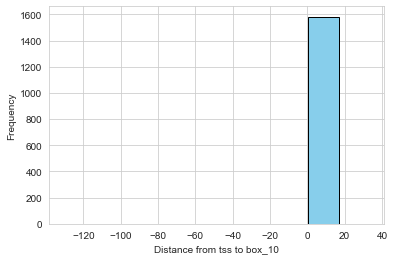

In [33]:
plt.hist(tss_box_10, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Distance from tss to box_10')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

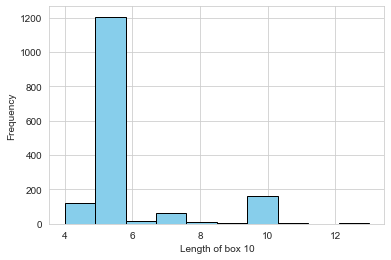

In [34]:
plt.hist(box_10_len, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Length of box 10')
plt.ylabel('Frequency')


Text(0, 0.5, 'Frequency')

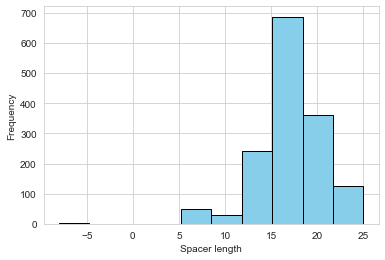

In [35]:
plt.hist(spacer, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Spacer length')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

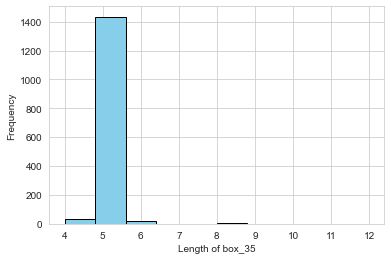

In [36]:
plt.hist(box_35_len, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Length of box_35')
plt.ylabel('Frequency')

In [40]:
#tu_promoter_dict.values() #relates TUs to promoters

# Setting up the features

## One hot setup

### Native Promoter Handling

In [168]:
#NOTE: THE MROH RANGES CURRENTLY DO NOT COUNT THE 8 INDEX SO 8 BASES DOWNSTREAM
# WILL ACTUALLY GIVE YOU 9 BASES - THIS NEEDS TO BE FIXED

#Non MROH
#one_hot_tus = mg1655.one_hot_encode_tu_promoters(n_upstream=50, n_downstream=10)
#one_hot_tus = one_hot_encode_tu_promoters(tu_table, local_align=False,upstream=50, downstream=10)
#one_hot_tus = one_hot_encode_tu_promoters(promoter_table, local_align=False,upstream=50, downstream=10)
#one_hot_tus = mg1655.one_hot_encode_tu_promoters(tu_table, local_align=False,n_upstream=50, n_downstream=10)


#MROH
#one_hot_tus = one_hot_encode_tu_promoters(tu_table, local_align=True, tss = True, tss_up = 50, tss_dn = 10, box_10_l=False, box_10_l_up = 15, box_10_l_dn = 20, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

#Current "best idea" range
#one_hot_tus = one_hot_encode_tu_promoters(promoter_table, local_align=True, tss = True, tss_up = 1, tss_dn = 1, box_10_l=True, box_10_l_up = 2, box_10_l_dn = 7, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=True, box_35_l_up = 2, box_35_l_dn = 7, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

#Just the -10 box for feature engineering testing
#one_hot_tus = one_hot_encode_tu_promoters(promoter_table, local_align=True, tss = False, tss_up = 2, tss_dn = 2, box_10_l=True, box_10_l_up = 2, box_10_l_dn = 7, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 2, box_35_l_dn = 8, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

#Intentionally bad set
#one_hot_tus = one_hot_encode_tu_promoters(tu_table, local_align=True, tss = False, tss_up = 3, tss_dn = 3, box_10_l=True, box_10_l_up = 0, box_10_l_dn = 6, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

#Assemble three separate ranges for PCA then combine them
one_hot_tss_native = one_hot_encode_tu_promoters(promoter_table, local_align=True, tss = True, tss_up = 1, tss_dn = 1, box_10_l=False, box_10_l_up = 15, box_10_l_dn = 20, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)
one_hot_m10_native = one_hot_encode_tu_promoters(promoter_table, local_align=True, tss = False, tss_up = 1, tss_dn = 1, box_10_l=True, box_10_l_up = 1, box_10_l_dn = 6, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)
one_hot_m35_native = one_hot_encode_tu_promoters(promoter_table, local_align=True, tss = False, tss_up = 1, tss_dn = 1, box_10_l=False, box_10_l_up = 15, box_10_l_dn = 20, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=True, box_35_l_up = 1, box_35_l_dn = 6, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

one_hot_all_native = pd.DataFrame(index = one_hot_tss_native.index)
one_hot_all_native = one_hot_all_native.join([one_hot_tss_native,one_hot_m10_native,one_hot_m35_native])

### Urtecho (2019) Handling

In [66]:
data_urtecho2019.head()

,Expr,Full Promoters,Background_Up,UP,Buffer_UP,m35,Spacer,m10,Buffer_TSS,TSS,Background_Down
Names,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0.056887,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGGATGTCGCTCGCGAACTATT,GCG,TTGACA,CTTTATGCTTCGGCTCG,GTTGTA,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0.057433,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGAAAATTTTTTTTCAAAAGTA,GCG,ATTACA,TCGCGCATGATCGAAAG,GATAAC,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0.067989,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GGAAAATTTTTTTTCAAAAGTA,GCG,TTTACC,AAAACTCATTTTATTTT,GATAAC,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0.075731,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,TTGAGCAGGCTTATCAGCTGGTGGTGGCAATCAACGGCCCACTGGC...,GAAAATATATTTTTCAAAAGTA,GCG,TTAAGA,TTTCCATTAGCGAGTAT,GTTAAA,AGCAGG,A,TCAGCCGCTGCGGATGCGATTAAGCGAAC
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0.077008,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,GCGGCGTAAACGCCTTATCCGGCCTACGGAGGGTGCGGGAATTTGT...,GCGCAAGCGTCGCATCAGGCAG,TCG,TTTACA,CTTTATGCTTCGGCTCG,GATAAC,TTATCC,A,GCCTACGGAGGGTGCGGGAATTTGTAGGC


In [71]:
loc_tss_urt2019 = 120
loc_m10U_urt2019 = 108
loc_spacerU_urt2019 = 91
loc_m35U_urt2019 = 85
#print(data_urtecho2019['Full Promoters'].loc[0][loc_tss_urt2019])
#print(data_urtecho2019['Full Promoters'].loc[0][loc_m10U_urt2019:loc_m10D_urt2019])
#print(data_urtecho2019['Full Promoters'].loc[0][loc_spacerU_urt2019:loc_spacerD_urt2019])
#print(data_urtecho2019['Full Promoters'].loc[0][loc_m35U_urt2019:loc_m35D_urt2019])

In [64]:
'''

# DataFrame to hold the one-hot encoded features
urtecho_one_hot = pd.DataFrame(index = data_urtecho2019.index)

for feature, sequence in data_urtecho2019.iloc[:, 2:].items():
    feature_one_hot = sequence.apply(one_hot_encode_sequence_manual, args = (feature,))
    urtecho_one_hot = pd.concat(
        objs = [urtecho_one_hot, feature_one_hot],
        ignore_index = False,
        axis = 1,
    )
urtecho_one_hot.head()

'''

,Background_Up_0_A,Background_Up_0_C,Background_Up_0_G,Background_Up_0_T,Background_Up_1_A,Background_Up_1_C,Background_Up_1_G,Background_Up_1_T,Background_Up_2_A,Background_Up_2_C,...,Background_Down_26_G,Background_Down_26_T,Background_Down_27_A,Background_Down_27_C,Background_Down_27_G,Background_Down_27_T,Background_Down_28_A,Background_Down_28_C,Background_Down_28_G,Background_Down_28_T
Names,,,,,,,,,,,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


In [114]:
#TSS
cur_feat_name = 'tss_'
buffer = 1
len_feature = 1
cur_u = loc_tss_urt2019-buffer
cur_d = loc_tss_urt2019+buffer+len_feature
one_hot_index = []
one_hot_rows = []
for cur_index,cur_row in data_urtecho2019.iterrows():

    cur_seq = cur_row['Full Promoters'][cur_u:cur_d]
    cur_oh = one_hot_encode_sequence_manual(cur_seq)
    cur_oh.index = reindex_one_hot(cur_oh.index, buffer, buffer+len_feature, prefix=cur_feat_name)
     
    one_hot_rows.append(cur_oh)

one_hot_tss_urt2019 = pd.DataFrame(one_hot_rows, index=data_urtecho2019.index)
one_hot_tss_urt2019.head()

,tss_-1_A,tss_-1_C,tss_-1_G,tss_-1_T,tss_0_A,tss_0_C,tss_0_G,tss_0_T,tss_1_A,tss_1_C,tss_1_G,tss_1_T
Names,,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0,0,1,0,1,0,0,0,0,0,0,1
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0,0,1,0,1,0,0,0,0,0,0,1
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0,0,1,0,1,0,0,0,0,0,0,1
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0,0,1,0,1,0,0,0,0,0,0,1
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0,1,0,0,1,0,0,0,0,0,1,0


In [169]:
#M10
cur_feat_name = 'm10U_'
buffer = 1
len_feature = 6
cur_u = loc_m10U_urt2019-buffer
cur_d = loc_m10U_urt2019+buffer+len_feature
one_hot_index = []
one_hot_rows = []
for cur_index,cur_row in data_urtecho2019.iterrows():

    cur_seq = cur_row['Full Promoters'][cur_u:cur_d]
    cur_oh = one_hot_encode_sequence_manual(cur_seq)
    cur_oh.index = reindex_one_hot(cur_oh.index, buffer, len_feature+buffer, prefix=cur_feat_name)
     
    one_hot_rows.append(cur_oh)

one_hot_m10_urt2019 = pd.DataFrame(one_hot_rows, index=data_urtecho2019.index)
one_hot_m10_urt2019.head()

,m10U_-1_A,m10U_-1_C,m10U_-1_G,m10U_-1_T,m10U_0_A,m10U_0_C,m10U_0_G,m10U_0_T,m10U_1_A,m10U_1_C,...,m10U_4_G,m10U_4_T,m10U_5_A,m10U_5_C,m10U_5_G,m10U_5_T,m10U_6_A,m10U_6_C,m10U_6_G,m10U_6_T
Names,,,,,,,,,,,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0,0,1,0,0,0,1,0,0,0,...,0,1,1,0,0,0,1,0,0,0
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0,0,0,1,0,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0,0,1,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,1


In [170]:
#M35
cur_feat_name = 'm35U_'
buffer = 1
len_feature = 6
cur_u = loc_m35U_urt2019-buffer
cur_d = loc_m35U_urt2019+buffer+len_feature
one_hot_index = []
one_hot_rows = []
for cur_index,cur_row in data_urtecho2019.iterrows():

    cur_seq = cur_row['Full Promoters'][cur_u:cur_d]
    cur_oh = one_hot_encode_sequence_manual(cur_seq)
    cur_oh.index = reindex_one_hot(cur_oh.index, buffer, len_feature+buffer, prefix=cur_feat_name)
     
    one_hot_rows.append(cur_oh)

one_hot_m35_urt2019 = pd.DataFrame(one_hot_rows, index=data_urtecho2019.index)
one_hot_m35_urt2019.head()

,m35U_-1_A,m35U_-1_C,m35U_-1_G,m35U_-1_T,m35U_0_A,m35U_0_C,m35U_0_G,m35U_0_T,m35U_1_A,m35U_1_C,...,m35U_4_G,m35U_4_T,m35U_5_A,m35U_5_C,m35U_5_G,m35U_5_T,m35U_6_A,m35U_6_C,m35U_6_G,m35U_6_T
Names,,,,,,,,,,,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0,0,1,0,0,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0


## Kmers

In [51]:
# KMER TESTING
#one_hot_tus_local = one_hot_encode_tu_promoters(local_align=True, tss = False, tss_up = 3, tss_dn = 3, box_10_l=True, box_10_l_up = 0, box_10_l_dn = 6, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

#N_range = 10
#sequence = mg1655.get_sequence(42037.0-N_range, 42037.0+N_range, -1)
#print(sequence)
#size = 3 #k
#kmer_list = getKmers(sequence, size)
#kmer_list

## Additional genomic features

In [304]:
mg1655.cid_boundaries

[50000,
 142779,
 223485,
 446815,
 927474,
 985894,
 1080000,
 1195008,
 1301085,
 1577657,
 1799393,
 1852621,
 2102875,
 2259719,
 2380722,
 2533498,
 2726069,
 2905711,
 2996372,
 3297098,
 3423423,
 3440040,
 3652182,
 3811250,
 3941516,
 4035239,
 4166484,
 4470986]

In [52]:
#Example demonstrating what is extracted with featurize_promoter and how
feature_dict = mg1655.featurize_promoter(tss = 21120, strand = 1, minus_10_motif = M_prib_sigma70, minus_35_motif = M_m35_sigma70, minus_10_search = (-20, 0), minus_35_search = (-45, -25), usr = (-65, -45), dsr = (9, 20))
print(feature_dict)
promoter_table.head()

{'m10_sequence': 'GACAAT', 'm10_score': -6.042685, 'm10_location': -10.5, 'm35_sequence': 'CTCCCA', 'm35_score': -8.045082, 'm35_location': -31.5, 'spacer_sequence': Seq('AAATGTGTTCTATATGG', IUPACAmbiguousDNA()), 'spacer_length': 17, 'spacer_at': 0.7058823529411764, 'usr_at': 0.6666666666666666, 'dsr_ag': 0.3333333333333333}


,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
p_0021120,rpsT,-1.0,21120.0,Sigma70,21125.0,21131.0,21148.0,21154.0,20771.0,21120.0,349.0
p_0021210,rpsT,-1.0,21210.0,Sigma70,21215.0,21221.0,21234.0,21240.0,20771.0,21210.0,439.0
p_0042037,caiTABCDE,-1.0,42037.0,Sigma70,42044.0,42049.0,42071.0,42076.0,34781.0,42037.0,7256.0
p_0052034,apaGH,-1.0,52034.0,Sigma70,52040.0,52046.0,52061.0,52067.0,50380.0,52034.0,1654.0
p_0052588,rsmA-apaGH,-1.0,52588.0,Sigma70,52593.0,52599.0,52621.0,52627.0,50380.0,52588.0,2208.0


In [306]:
#Bitome2 function
#featurize_promoter
buffer_up_tss = 15
buffer_down_tss = 5
dist2orig = [];
strands = [];
at_density_tss = [];
m10_scores_70_auto = [];
m10_location_70_auto = [];
m35_scores_70_auto = [];
m35_location_70_auto = [];
spacer_length_70_auto = [];
spacer_at_70_auto = [];
usr_at_auto = [];
dsr_ag_auto = [];
leading = [];
lagging = [];
terminus = [];

seq_max = len(mg1655.sequence)
origin1 = mg1655.origin[0]
origin2 = mg1655.origin[1]

for cur_index, cur_row in promoter_table.iterrows():
    cur_tss = int(cur_row['tss'])
    cur_dist2orig = np.min([genome_point_to_point(origin1, cur_tss, seq_max), genome_point_to_point(origin2, cur_tss, seq_max)])
    dist2orig.append(cur_dist2orig)
    
    cur_strand = int(cur_row['strand'])
    strands.append(cur_strand)

    #AT Density at the TSS
    if cur_strand == 1:
        cur_seq_tss = mg1655.get_sequence(cur_tss-buffer_up_tss, cur_tss+buffer_down_tss, cur_strand)
    else:
        cur_seq_tss = mg1655.get_sequence(cur_tss-buffer_down_tss, cur_tss+buffer_up_tss, cur_strand)
    cur_gc = GC(cur_seq_tss) / 100 #This returns a fraction of GC, so we subtract from 1 to get AT
    cur_at = 1-cur_gc
    at_density_tss.append(cur_at)

    cur_feature = pd.Series([cur_tss, cur_tss,cur_strand], index = ["left", "right", "strand"])
    cur_region = mg1655.replication_region(cur_feature)
    if cur_region == 'leading':
        leading.append(1)
        lagging.append(0)
        terminus.append(0)
    elif cur_region == 'lagging':
        leading.append(0)
        lagging.append(1)
        terminus.append(0)
    else:
        leading.append(0)
        lagging.append(0)
        terminus.append(1)
    
    cur_feature_dict = mg1655.featurize_promoter(tss = cur_tss, strand = cur_strand, minus_10_motif = M_prib_sigma70, minus_35_motif = M_m35_sigma70, minus_10_search = (-20, 0), minus_35_search = (-45, -25), usr = (-65, -45), dsr = (9, 20))

    m10_scores_70_auto.append(cur_feature_dict['m10_score'])
    m10_location_70_auto.append(cur_feature_dict['m10_location'])
    m35_scores_70_auto.append(cur_feature_dict['m35_score'])
    m35_location_70_auto.append(cur_feature_dict['m35_location'])
    spacer_length_70_auto.append(cur_feature_dict['spacer_length'])
    spacer_at_70_auto.append(cur_feature_dict['spacer_at'])
    usr_at_auto.append(cur_feature_dict['usr_at'])
    dsr_ag_auto.append(cur_feature_dict['dsr_ag'])

df_dist2orig = pd.DataFrame(dist2orig,index= promoter_table.index)
df_dist2orig.columns = ['dist2orig']

df_strand = pd.DataFrame(strands,index= promoter_table.index)
df_strand.columns = ['strand']

df_at_density_tss = pd.DataFrame(at_density_tss,index= promoter_table.index)
df_at_density_tss.columns = ['AT_density_TSS']

df_m10_scores_70_auto = pd.DataFrame(m10_scores_70_auto,index= promoter_table.index)
df_m10_scores_70_auto.columns = ['m10_scores_70_auto']

df_m10_location_70_auto = pd.DataFrame(m10_location_70_auto,index= promoter_table.index)
df_m10_location_70_auto.columns = ['m10_location_70_auto']

df_m35_scores_70_auto = pd.DataFrame(m35_scores_70_auto,index= promoter_table.index)
df_m35_scores_70_auto.columns = ['m35_scores_70_auto']

df_m35_location_70_auto = pd.DataFrame(m35_location_70_auto,index= promoter_table.index)
df_m35_location_70_auto.columns = ['m35_location_70_auto']

df_spacer_length_70_auto = pd.DataFrame(spacer_length_70_auto,index= promoter_table.index)
df_spacer_length_70_auto.columns = ['spacer_length_70_auto']

df_spacer_at_70_auto = pd.DataFrame(spacer_at_70_auto,index= promoter_table.index)
df_spacer_at_70_auto.columns = ['spacer_at_70_auto']

df_usr_at_auto = pd.DataFrame(usr_at_auto,index= promoter_table.index)
df_usr_at_auto.columns = ['usr_at_auto']

df_dsr_ag_auto = pd.DataFrame(dsr_ag_auto,index= promoter_table.index)
df_dsr_ag_auto.columns = ['dsr_ag_auto']

df_leading = pd.DataFrame(leading,index= promoter_table.index)
df_leading.columns = ['leading']

df_lagging = pd.DataFrame(lagging,index= promoter_table.index)
df_lagging.columns = ['lagging']

df_terminus = pd.DataFrame(terminus,index= promoter_table.index)
df_terminus.columns = ['terminus']

In [ ]:
#Regional melting temp, location and other genomic organization features
#Bitome2 function
#genome_organization_table

In [ ]:
#Spacer
#inter_feature_distance

In [ ]:
#Leading/lagging/terminus
#replication_region

<Axes: >

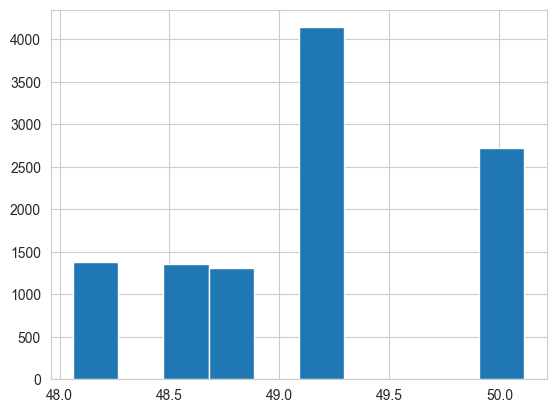

In [68]:
## Rigidity
data_urtecho2019['Spacer'].apply(calc_sliding_rigidity).hist()

## Shape

In [171]:
#Bitome2 functions
#encode_boxes
#get_dna_shape_for_features
#get_dna_shape
#tss_search_shape_stats
#tss_reference_shape

In [125]:
promoter_table.head()

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
p_0021120,rpsT,-1.0,21120.0,Sigma70,21125.0,21131.0,21148.0,21154.0,20771.0,21120.0,349.0
p_0021210,rpsT,-1.0,21210.0,Sigma70,21215.0,21221.0,21234.0,21240.0,20771.0,21210.0,439.0
p_0042037,caiTABCDE,-1.0,42037.0,Sigma70,42044.0,42049.0,42071.0,42076.0,34781.0,42037.0,7256.0
p_0052034,apaGH,-1.0,52034.0,Sigma70,52040.0,52046.0,52061.0,52067.0,50380.0,52034.0,1654.0
p_0052588,rsmA-apaGH,-1.0,52588.0,Sigma70,52593.0,52599.0,52621.0,52627.0,50380.0,52588.0,2208.0


In [148]:
cur_tss = int(21120.0)
cur_strand = int(-1.0)
length_feature = 1
name_feature = 'TSS'
buffer = 2
cur_shape_df = mg1655.get_dna_shape(left=(cur_tss-buffer), right= (cur_tss+buffer), strand=cur_strand)
cur_shape_df.head()

,Opening,Rise,Stretch,EP,Tilt,Shear,ProT,Buckle,Shift,HelT,Stagger,Slide,MGW,Roll
21122,0.47,3.335,-0.03,-4.85,-0.380,0.27,-6.12,2.27,0.095,33.520,-0.07,-1.575,5.65,2.055
21121,0.28,3.355,-0.04,-5.23,-0.225,-0.25,-3.40,-0.37,0.090,32.710,0.04,-1.690,5.43,1.460
21120,0.32,3.370,-0.04,-5.37,0.160,-0.27,-2.72,0.77,0.065,35.040,0.06,-1.670,4.96,-1.650
21119,0.46,3.435,-0.04,-5.29,-0.550,0.30,-2.20,-0.40,-0.025,35.175,0.00,-1.785,4.72,-2.115
21118,0.28,3.450,-0.03,-5.64,0.505,0.28,-1.50,-3.50,-0.200,33.455,0.14,-1.845,4.51,-2.685


In [149]:
helt =  list(cur_shape_df['HelT'])
roll =  list(cur_shape_df['Roll'])
mgw = list(cur_shape_df['MGW'])
prot=  list(cur_shape_df['ProT'])
slide = list(cur_shape_df['Slide'])
stretch = list(cur_shape_df['Stretch'])
stagger = list(cur_shape_df['Stagger'])
opening = list(cur_shape_df['Opening'])
ep = list(cur_shape_df['EP'])
shift = list(cur_shape_df['Shift'])
rise = list(cur_shape_df['Rise'])
tilt = list(cur_shape_df['Tilt'])
buckle = list(cur_shape_df['Buckle'])
shear = list(cur_shape_df['Shear'])

if cur_strand == -1:
    helt.reverse()
    mgw.reverse()
    prot.reverse()
    roll.reverse()
    slide.reverse()
    stretch.reverse()
    stagger.reverse()
    opening.reverse()
    ep.reverse()
    shift.reverse()
    rise.reverse()
    tilt.reverse()
    buckle.reverse()
    shear.reverse()

# [Modified] Added updated shape features
cur_shape_feature = {}
temp = {'HelT':helt, 'MGW':mgw,'ProT':prot, 'Roll':roll,'Slide':slide,
        'Stretch':stretch,'Stagger': stagger,'Opening':opening,'EP': ep, 
        'Shift': shift, 'Rise': rise, 'TilT': tilt, 'Buckle': buckle, 'Shear': shear}
for shape in temp.keys():
    for i in range(2*buffer+length_feature):
        cur_shape_feature[shape+'_'+name_feature+'_'+ str(i)] = temp[shape][i] 

In [150]:
cur_shape_feature.keys()

dict_keys(['HelT_TSS_0', 'HelT_TSS_1', 'HelT_TSS_2', 'HelT_TSS_3', 'HelT_TSS_4', 'MGW_TSS_0', 'MGW_TSS_1', 'MGW_TSS_2', 'MGW_TSS_3', 'MGW_TSS_4', 'ProT_TSS_0', 'ProT_TSS_1', 'ProT_TSS_2', 'ProT_TSS_3', 'ProT_TSS_4', 'Roll_TSS_0', 'Roll_TSS_1', 'Roll_TSS_2', 'Roll_TSS_3', 'Roll_TSS_4', 'Slide_TSS_0', 'Slide_TSS_1', 'Slide_TSS_2', 'Slide_TSS_3', 'Slide_TSS_4', 'Stretch_TSS_0', 'Stretch_TSS_1', 'Stretch_TSS_2', 'Stretch_TSS_3', 'Stretch_TSS_4', 'Stagger_TSS_0', 'Stagger_TSS_1', 'Stagger_TSS_2', 'Stagger_TSS_3', 'Stagger_TSS_4', 'Opening_TSS_0', 'Opening_TSS_1', 'Opening_TSS_2', 'Opening_TSS_3', 'Opening_TSS_4', 'EP_TSS_0', 'EP_TSS_1', 'EP_TSS_2', 'EP_TSS_3', 'EP_TSS_4', 'Shift_TSS_0', 'Shift_TSS_1', 'Shift_TSS_2', 'Shift_TSS_3', 'Shift_TSS_4', 'Rise_TSS_0', 'Rise_TSS_1', 'Rise_TSS_2', 'Rise_TSS_3', 'Rise_TSS_4', 'TilT_TSS_0', 'TilT_TSS_1', 'TilT_TSS_2', 'TilT_TSS_3', 'TilT_TSS_4', 'Buckle_TSS_0', 'Buckle_TSS_1', 'Buckle_TSS_2', 'Buckle_TSS_3', 'Buckle_TSS_4', 'Shear_TSS_0', 'Shear_TSS_1',

In [142]:
cur_shape_feature['HelT_TSS_1']

35.175

In [152]:
df_shape_tss = pd.DataFrame(columns=list(cur_shape_feature.keys()),index=promoter_table.index)
df_shape_tss.head()

,HelT_TSS_0,HelT_TSS_1,HelT_TSS_2,HelT_TSS_3,HelT_TSS_4,MGW_TSS_0,MGW_TSS_1,MGW_TSS_2,MGW_TSS_3,MGW_TSS_4,...,Buckle_TSS_0,Buckle_TSS_1,Buckle_TSS_2,Buckle_TSS_3,Buckle_TSS_4,Shear_TSS_0,Shear_TSS_1,Shear_TSS_2,Shear_TSS_3,Shear_TSS_4
p_0021120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p_0021210,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p_0042037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p_0052034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
p_0052588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [153]:
#Now populate the dataframe based on the test example
length_feature = 1
name_feature = 'TSS'
buffer = 2
for cur_index, cur_row in promoter_table.iterrows():
    cur_tss = int(cur_row['tss'])
    cur_strand = int(cur_row['strand'])
    cur_shape_df = mg1655.get_dna_shape(left=(cur_tss-buffer), right= (cur_tss+buffer), strand=cur_strand)

    cur_helt =  list(cur_shape_df['HelT'])
    cur_roll =  list(cur_shape_df['Roll'])
    cur_mgw = list(cur_shape_df['MGW'])
    cur_prot=  list(cur_shape_df['ProT'])
    cur_slide = list(cur_shape_df['Slide'])
    cur_stretch = list(cur_shape_df['Stretch'])
    cur_stagger = list(cur_shape_df['Stagger'])
    cur_opening = list(cur_shape_df['Opening'])
    cur_ep = list(cur_shape_df['EP'])
    cur_shift = list(cur_shape_df['Shift'])
    cur_rise = list(cur_shape_df['Rise'])
    cur_tilt = list(cur_shape_df['Tilt'])
    cur_buckle = list(cur_shape_df['Buckle'])
    cur_shear = list(cur_shape_df['Shear'])
    
    if cur_strand == -1:
        cur_helt.reverse()
        cur_mgw.reverse()
        cur_prot.reverse()
        cur_roll.reverse()
        cur_slide.reverse()
        cur_stretch.reverse()
        cur_stagger.reverse()
        cur_opening.reverse()
        cur_ep.reverse()
        cur_shift.reverse()
        cur_rise.reverse()
        cur_tilt.reverse()
        cur_buckle.reverse()
        cur_shear.reverse()
    
    # [Modified] Added updated shape features
    temp = {'HelT':cur_helt, 'MGW':cur_mgw,'ProT':cur_prot, 'Roll':cur_roll,'Slide':cur_slide,
            'Stretch':cur_stretch,'Stagger': cur_stagger,'Opening':cur_opening,'EP': cur_ep, 
            'Shift': cur_shift, 'Rise': cur_rise, 'TilT': cur_tilt, 'Buckle': cur_buckle, 'Shear': cur_shear}
    for shape in temp.keys():
        for i in range(2*buffer+length_feature):
            cur_feature_name = shape+'_'+name_feature+'_'+ str(i)
            df_shape_tss.at[cur_index, cur_feature_name] = temp[shape][i]


In [154]:
df_shape_tss.head()

,HelT_TSS_0,HelT_TSS_1,HelT_TSS_2,HelT_TSS_3,HelT_TSS_4,MGW_TSS_0,MGW_TSS_1,MGW_TSS_2,MGW_TSS_3,MGW_TSS_4,...,Buckle_TSS_0,Buckle_TSS_1,Buckle_TSS_2,Buckle_TSS_3,Buckle_TSS_4,Shear_TSS_0,Shear_TSS_1,Shear_TSS_2,Shear_TSS_3,Shear_TSS_4
p_0021120,33.455,35.175,35.04,32.71,33.52,4.51,4.72,4.96,5.43,5.65,...,-3.5,-0.4,0.77,-0.37,2.27,0.28,0.3,-0.27,-0.25,0.27
p_0021210,34.16,34.85,34.28,34.155,34.94,5.23,5.06,5.41,5.71,5.67,...,-0.53,-0.47,0.35,-0.07,-0.59,0.27,0.28,-0.25,0.25,-0.26
p_0042037,34.16,35.485,34.33,33.055,34.86,5.23,4.53,5.0,5.82,5.8,...,-0.53,-0.29,4.28,-0.87,-1.01,0.27,0.27,-0.24,0.11,-0.1
p_0052034,34.915,33.745,33.495,34.16,34.89,5.15,4.69,5.08,5.23,5.24,...,2.51,-3.33,-5.67,-0.53,-1.54,-0.1,-0.14,0.09,0.27,0.27
p_0052588,35.115,35.405,33.77,32.59,32.61,4.17,4.61,4.73,4.85,5.4,...,-3.28,-0.64,1.06,4.67,0.99,0.26,-0.28,-0.3,-0.26,0.09


In [ ]:
#Usage of the PCA work


#motif_data = pd.read_csv("data/motif_data.csv") # motif_data_table without motif search 

# find tss location for each (gene and tu) combination
#tss_loc = []
#for g in mg1655.genes:   
#    for tu in g.transcription_units:
#        if tu.tss == None or int(tu.tss) < 200:
#            continue
#        tss_loc.append(tu.tss)    
#motif_data["tss_loc"] = tss_loc

#motif_genes = motif_data["ID"].unique()
#gene_m35_shape = pd.DataFrame(columns = motif_genes)


# [m10_shape by genes]
#gene_m10_shape = pd.DataFrame(columns = motif_genes)

#for gene in motif_genes: 
#    res = loc_find(gene, motif_data)
#    m10_loc = res["m10_s70_loc"][0]
#    m10_shape = get_shape(m10_loc+2, m10_loc+7, shape_table,bitome) 
    
#    shape_fea = m35_shape.columns
#    vec_m10 = [m10_shape[shape][ind] for ind in m10_shape.index for shape in shape_fea]
 #   gene_m10_shape[gene] = vec_m10
    
# rename index
#index_name =["m10" + '_' + str(i) + '_' + shape_fea[j] for i in range(1,7) for j in range(0,14)]
#gene_m10_shape.index = index_name
#gene_m10_shape = gene_m10_shape.T

#res_pca_m10, pca_var_m10, weights_m10 = features_pca_sc(gene_m10_shape, 0.999) 
#dims10 = np.where(pca_var_m10 > 0.9)[0][0]

## Motif Scores (PSSM etc)

### Native Promoter Handling

In [55]:
#motif_search #Returns an object with the score
buffer = 2
m10_scores_70 = [];
for cur_index,cur_promoter in promoter_table.iterrows():
    if not np.isnan(cur_promoter['box_10_left']):
        pos_left = int(cur_promoter['box_10_left']-buffer); #Not sure if these needs to take strand into account
        pos_right = int(cur_promoter['box_10_right']+buffer);
    else:
        pos_left = int(cur_promoter['left']);
        pos_right = int(cur_promoter['right']);

    cur_strand = int(cur_promoter['strand']);
    cur_pssm = pd.DataFrame(M_prib['Sigma70']);
    result_table = mg1655.motif_search(left=pos_left, right=pos_right, strand=cur_strand, motif_pssm=cur_pssm, n_best_matches=1)
    m10_scores_70.append(result_table['log_odds'])
df_m10 = pd.DataFrame(m10_scores_70,index= promoter_table.index)
df_m10.columns = ['m10_scores_70']
df_m10.head()

,m10_scores_70
p_0021120,-6.214814
p_0021210,-4.207741
p_0042037,-5.778186
p_0052034,-3.290289
p_0052588,-2.906711


In [56]:
#motif_search #Returns an object with the score
buffer = 2
m35_scores_70 = [];
for cur_index,cur_promoter in promoter_table.iterrows():
    if not np.isnan(cur_promoter['box_35_left']):
        pos_left = int(cur_promoter['box_35_left']-buffer); #Not sure if these needs to take strand into account
        pos_right = int(cur_promoter['box_35_right']+buffer);
    else:
        pos_left = int(cur_promoter['left']);
        pos_right = int(cur_promoter['right']);
    cur_strand = int(cur_promoter['strand']);
    cur_pssm = pd.DataFrame(M_m35['Sigma70']);
    result_table = mg1655.motif_search(left=pos_left, right=pos_right, strand=cur_strand, motif_pssm=cur_pssm, n_best_matches=1)
    m35_scores_70.append(result_table['log_odds'])
df_m35 = pd.DataFrame(m35_scores_70,index= promoter_table.index)
df_m35.columns = ['m35_scores_70']
df_m35.head()

,m35_scores_70
p_0021120,-3.353553
p_0021210,-5.039236
p_0042037,-7.057679
p_0052034,-4.868948
p_0052588,-8.116343


### Urtecho (2019) Handling

## PCA

In [ ]:
#Show that the MROH has fewer dimensions, especially when restricted to a narrow range

In [237]:
n_comp_10 = 6
pca_loadings_10, exp_var_10, weights_10 = features_pca_sc(one_hot_prom_10, n_comp_10)
weights_10 = weights_10.set_index(one_hot_prom_10.index)
weights_10.columns=["Box10_PC_"+str(i) for i in range(0, n_comp_10)]
print(exp_var_10)

[0.05455041 0.10829147 0.15683694 0.202377   0.24506183 0.28480815]


In [238]:
n_comp_35 = 6
pca_loadings_35, exp_var_35, weights_35 = features_pca_sc(one_hot_prom_35, n_comp_35)
weights_35 = weights_35.set_index(one_hot_prom_35.index)
weights_35.columns=["Box35_PC_"+str(i) for i in range(0, n_comp_35)]
print(exp_var_35)

[0.06408093 0.11349681 0.15917537 0.20209864 0.24397816 0.28407708]


In [280]:
#Shape PCA
n_comp_shape_tss = 3
pca_loadings_shape_tss, exp_var_shape_tss, weights_shape_tss = features_pca_sc(df_shape_tss, n_comp_shape_tss)
weights_shape_tss = weights_shape_tss.set_index(df_shape_tss.index)
weights_shape_tss.columns=["Shape_TSS_PC_"+str(i) for i in range(0, n_comp_shape_tss)]
print(exp_var_shape_tss)

[0.14637022 0.26499577 0.32754878]


## Add features related to a calculated distance from an ideal

In [187]:
#Spacer distance from ideal
ideal_spacer = 17
#Absolute distance from ideal
df_spacer_length_70_distanceAbs = pd.DataFrame(columns=['spacer_length_70_distanceAbs'],index=promoter_table.index)
df_spacer_length_70_distanceAbs['spacer_length_70_distanceAbs']=abs(df_spacer_length_70_auto-17)

#Signed distance from ideal
df_spacer_length_70_distanceSplit = pd.DataFrame(columns=['spacer_length_70_distanceLong','spacer_length_70_distanceShort'],index=promoter_table.index)
#Handle long spacers
df_temp = df_spacer_length_70_auto-ideal_spacer
df_temp[df_temp<=0] = 0
df_spacer_length_70_distanceSplit['spacer_length_70_distanceLong'] = df_temp
#Handle short spacers
df_temp = ideal_spacer-df_spacer_length_70_auto
df_temp[df_temp<=0] = 0
df_spacer_length_70_distanceSplit['spacer_length_70_distanceShort'] = df_temp
df_spacer_length_70_distanceSplit.head()

,spacer_length_70_distanceLong,spacer_length_70_distanceShort
p_0021120,2,0
p_0021210,0,2
p_0042037,6,0
p_0052034,0,0
p_0052588,7,0


In [292]:
# Transform PCA into distance from ideal

# First identify the ideal spot in PCA space
# Generate the features of the "ideal sample" - this could be an actual sample or an average of high performing samples or a different computed ideal
# Grab a set of high expression promoters, say the top 10% of all, by sorting promoter1cluster target - print out how many promoters are used
num_top = round(len(promoter_1cluster_target)/10)
expr_sorted = promoter_1cluster_target.sort_values(by=[0], ascending=False)
prom_top_df = expr_sorted[0].iloc[0:num_top]
prom_top_list = list(prom_top.index)

# Take the average of the features of those, call it the 'ideal'
#shape_tss_top = df_shape_tss.loc[prom_top_list] #If you want to use the raw shape as the sequence
shape_tss_top = weights_shape_tss.loc[prom_top_list] 
ideal_shape_tss = shape_tss_top.mean(0)
shape_tss_diffs = weights_shape_tss - ideal_shape_tss
# Now compute the distance of everything relative to that
#Absolute distance

df_shape_tss_diffsAbs = pd.DataFrame(abs(shape_tss_diffs),index=shape_tss_diffs.index)
cur_cols = df_shape_tss_diffsAbs.columns
new_cols = []
for cur_col in cur_cols:
    new_col = cur_col+'_ideal'
    new_cols.append(new_col)
df_shape_tss_diffsAbs.columns = new_cols
df_shape_tss_diffsAbs.head()

#Then, create two signed PC variables for each PC. 
#The first signed PC is all the positive values from the ideal spot, the second signed PC is all the negative values from the ideal spot
#df_shape_tss_diffsSplit = pd.DataFrame(columns=['shape_tss_diffsPos','shape_tss_diffsNeg'],index=promoter_table.index)
#Handle positive deviation
#df_temp = df_spacer_length_70_auto-ideal_spacer
#df_temp[df_temp<=0] = 0
#df_spacer_length_70_distanceSplit['spacer_length_70_distanceLong'] = df_temp
#Handle negative deviation
#df_temp = ideal_spacer-df_spacer_length_70_auto
#df_temp[df_temp<=0] = 0
#df_spacer_length_70_distanceSplit['spacer_length_70_distanceShort'] = df_temp
#df_spacer_length_70_distanceSplit.head()


# Then, compute the PC loadings based on the real PCA



,Shape_TSS_PC_0_ideal,Shape_TSS_PC_1_ideal,Shape_TSS_PC_2_ideal
p_0021120,4.777685,0.060527,0.541827
p_0021210,4.297371,0.093274,0.762956
p_0042037,2.116268,2.556349,1.108308
p_0052034,0.547084,4.719294,0.316553
p_0052588,4.406685,0.349476,1.713540


## Combine all the desired features

In [172]:
#df_features = pd.DataFrame(index = one_hot_prom_35.index)
#Full set
#df_features = df_features.join([one_hot_prom_tss,weights_10,weights_35,weights_shape_tss,df_m10,df_m35,df_dist2orig, df_strand,df_at_density_tss, \
#df_spacer_length_70_auto, df_spacer_at_70_auto,df_spacer_length_70_distanceAbs,df_spacer_length_70_distanceSplit,df_shape_tss_diffsAbs,\
#df_m10_scores_70_auto, df_m10_location_70_auto, df_m35_scores_70_auto, df_m35_location_70_auto, df_usr_at_auto, df_dsr_ag_auto,\
#                                df_leading,df_lagging,df_terminus])

#Just variables that are individually correlated
#df_features = df_features.join([df_spacer_at_70_auto,df_spacer_length_70_distanceAbs,df_m10_scores_70_auto, df_m35_scores_70_auto, df_usr_at_auto, \
#                                df_leading,df_terminus])

#Just motifs
#df_features = df_features.join([one_hot_prom_tss,weights_10,weights_35,df_m10,df_m35])

#Just one hot
df_features_native = one_hot_all_native
df_features_native.head()

,tss_-1_A,tss_-1_C,tss_-1_G,tss_-1_T,tss_0_A,tss_0_C,tss_0_G,tss_0_T,tss_1_A,tss_1_C,...,m35U_4_G,m35U_4_T,m35U_5_A,m35U_5_C,m35U_5_G,m35U_5_T,m35U_6_A,m35U_6_C,m35U_6_G,m35U_6_T
p_0021120,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
p_0021210,0,1,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
p_0042037,1,0,0,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
p_0052034,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
p_0052588,0,0,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [171]:
#Urtecho data
df_features_urt2019 = pd.DataFrame(index = data_urtecho2019.index)
df_features_urt2019 = df_features_urt2019.join([one_hot_tss_urt2019,one_hot_m10_urt2019,one_hot_m35_urt2019])
df_features_urt2019.head()

,tss_-1_A,tss_-1_C,tss_-1_G,tss_-1_T,tss_0_A,tss_0_C,tss_0_G,tss_0_T,tss_1_A,tss_1_C,...,m35U_4_G,m35U_4_T,m35U_5_A,m35U_5_C,m35U_5_G,m35U_5_T,m35U_6_A,m35U_6_C,m35U_6_G,m35U_6_T
Names,,,,,,,,,,,,,,,,,,,,,
noUP-consensus35-lac-spacer-17bp-12T->G/11A->T/9A->G/8A->T/7T->A-bg977040:977190,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
gourse-326fold-up-35T->A/33G->T-ECK125137104-12T->G/7T->C-bg977040:977190,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
gourse-326fold-up-34G->T/30A->C-ECK125137405-12T->G/7T->C-bg977040:977190,0,0,1,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
gourse-136fold-up-33G->A/31C->G-ECK125137726-12T->G/11A->T/7T->A-bg977040:977190,0,0,1,0,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,1
noUP-34G->T-lac-spacer-17bp-12T->G/7T->C-bg4323949:4324099,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [ ]:
# Export features
# Export to csv
from datetime import date # Want to include date in csv so that we don't accidentally overwrite it
today = date.today()
today.strftime('%Y%m%d')
name = today.strftime('%Y%m%d')+'-feature-dataframe.csv'
path = r'feature-engineering-csv/'

df_features.to_csv(
    path_or_buf = path+name,
)

# Setting up train/test splits and testing models

In [308]:
#promoter_1cluster_target.loc['p_0008191',0]

1644.7067726971325

## Urtecho data

In [188]:
Xy_to_try = {}

Xy_to_try['1tss__wt'] = (df_features_urt2019, data_urtecho2019['Expr'])
    
#Reduce the set to just the 1tss
Xy_to_try = {
    '1tss__wt': Xy_to_try['1tss__wt']
}

## Native Data

In [181]:
#Here is where I need to replace XY_to_try with just the 1-promoter cluster data
#gene_promoter_1cluster
#promoter_1cluster_target

Xy_to_try_native = {}

promoter_names_1tss = []
promoter_oh_rows_1tss = []
promoter_exps_1tss = []

for cur_promoter in gene_promoter_1cluster.columns:
    
    promoter_tpm = promoter_1cluster_target.loc[cur_promoter,0]

    #Check if the promoter is among the valid to MROH - as in has -10 and -35 box specified
    if cur_promoter in df_features_native.index:
        promoter_names_1tss.append(cur_promoter)
        promoter_oh_rows_1tss.append(df_features_native.loc[cur_promoter])
        promoter_exps_1tss.append(promoter_tpm)
    
X_1tss = pd.DataFrame(promoter_oh_rows_1tss, index=promoter_names_1tss)
Xy_to_try_native['1tss__wt'] = (X_1tss, pd.Series(promoter_exps_1tss, index=promoter_names_1tss))
    
#Reduce the set to just the 1tss and avg wt
Xy_to_try_native = {
    '1tss__wt': Xy_to_try_native['1tss__wt']
}

In [174]:
len(promoter_names_1tss)

671

In [342]:
'''

Xy_to_try = {}

gene_names_avg = []
gene_oh_rows_avg = []
gene_exps_avg = []
gene_exps_avg_ctrl = []
gene_exps_avg_all = []

gene_names_1tss = []
gene_oh_rows_1tss = []
gene_exps_1tss = []
gene_exps_1tss_ctrl = []
gene_exps_1tss_all = []

for gene_row in mg1655.gene_table.itertuples():
    
    # handle the normal 1-hot
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    if tus_in_onehot and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]
        tu_one_hot_avg = tu_one_hots.mean(axis=0)
        gene_names_avg.append(gene_row.Index)
        gene_oh_rows_avg.append(tu_one_hot_avg)
        gene_exps_avg.append(gene_tpm)
        gene_exps_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_onehot) == 1:
            gene_names_1tss.append(gene_row.Index)
            gene_oh_rows_1tss.append(one_hot_tus.loc[tus_in_onehot[0]])
            gene_exps_1tss.append(gene_tpm)
            gene_exps_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_1tss_all.append(gene_tpm_all)

X_avg = pd.DataFrame(gene_oh_rows_avg, index=gene_names_avg)
Xy_to_try['prom_avg__wt'] = (X_avg, pd.Series(gene_exps_avg, index=gene_names_avg))
Xy_to_try['prom_avg__ctrl'] = (X_avg, pd.Series(gene_exps_avg_ctrl, index=gene_names_avg))
Xy_to_try['prom_avg__all'] = (X_avg, pd.Series(gene_exps_avg_all, index=gene_names_avg))

X_1tss = pd.DataFrame(gene_oh_rows_1tss, index=gene_names_1tss)
Xy_to_try['1tss__wt'] = (X_1tss, pd.Series(gene_exps_1tss, index=gene_names_1tss))
Xy_to_try['1tss__ctrl'] = (X_1tss, pd.Series(gene_exps_1tss_ctrl, index=gene_names_1tss))
Xy_to_try['1tss__all'] = (X_1tss, pd.Series(gene_exps_1tss_all, index=gene_names_1tss))

#Reduce the set to just the 1tss and avg wt
Xy_to_try = {
    '1tss__wt': Xy_to_try['1tss__wt'],
    'prom_avg__wt': Xy_to_try['prom_avg__wt']
}

'''

"\n\nXy_to_try = {}\n\ngene_names_avg = []\ngene_oh_rows_avg = []\ngene_exps_avg = []\ngene_exps_avg_ctrl = []\ngene_exps_avg_all = []\n\ngene_names_1tss = []\ngene_oh_rows_1tss = []\ngene_exps_1tss = []\ngene_exps_1tss_ctrl = []\ngene_exps_1tss_all = []\n\nfor gene_row in mg1655.gene_table.itertuples():\n    \n    # handle the normal 1-hot\n    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]\n    tus_in_onehot = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus.index)]\n    gene_tpm = gene_row.tpm\n    gene_tpm_ctrl = gene_row.tpm_ctrl\n    gene_tpm_all = gene_row.tpm_all\n    if tus_in_onehot and not pd.isna(gene_tpm):\n        \n        # handle the one-hot averaging\n        tu_one_hots = one_hot_tus.loc[tus_in_onehot, :]\n        tu_one_hot_avg = tu_one_hots.mean(axis=0)\n        gene_names_avg.append(gene_row.Index)\n        gene_oh_rows_avg.append(tu_one_hot_avg)\n        gene_exps_avg.append(gene_tpm)\n        gene_exps_avg_ctrl.append(gene_tpm_ctrl)\n        gene_e

## Testing

In [197]:
#Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=rng)
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=seed_set)

In [198]:
models_to_try = {
    'ElasticNet': ElasticNetCV(cv=5,random_state=seed_set),
    #'SVR': SVR(),
    #'RF': RandomForestRegressor(n_jobs=4,random_state=rng),
    'RF': RandomForestRegressor(n_jobs=4,random_state=seed_set),
    #'NN': MLPRegressor()
}

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Setting a gradient palette using color= is deprecated an

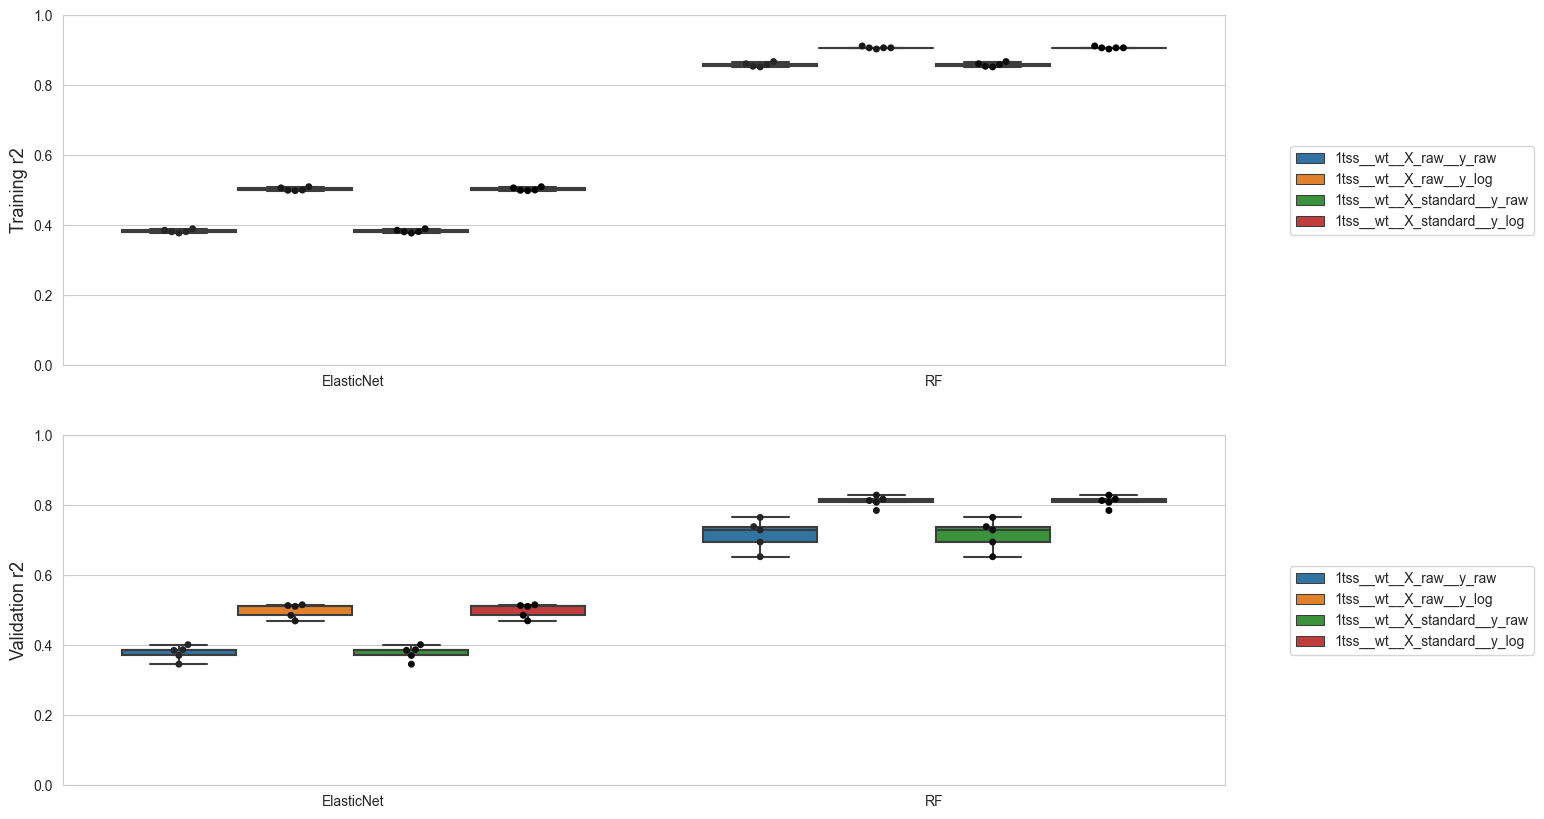

In [199]:

model_profile_df, ax_train, ax_val = profile_xy_and_models(rng,Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing= ['standard'], y_preprocessing=['log'],
                                                           verbose=False)


In [200]:
x_oh_fi_raw = Xy_train['1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

Permutation explainer: 1963it [08:02,  4.02it/s]                                                                       
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


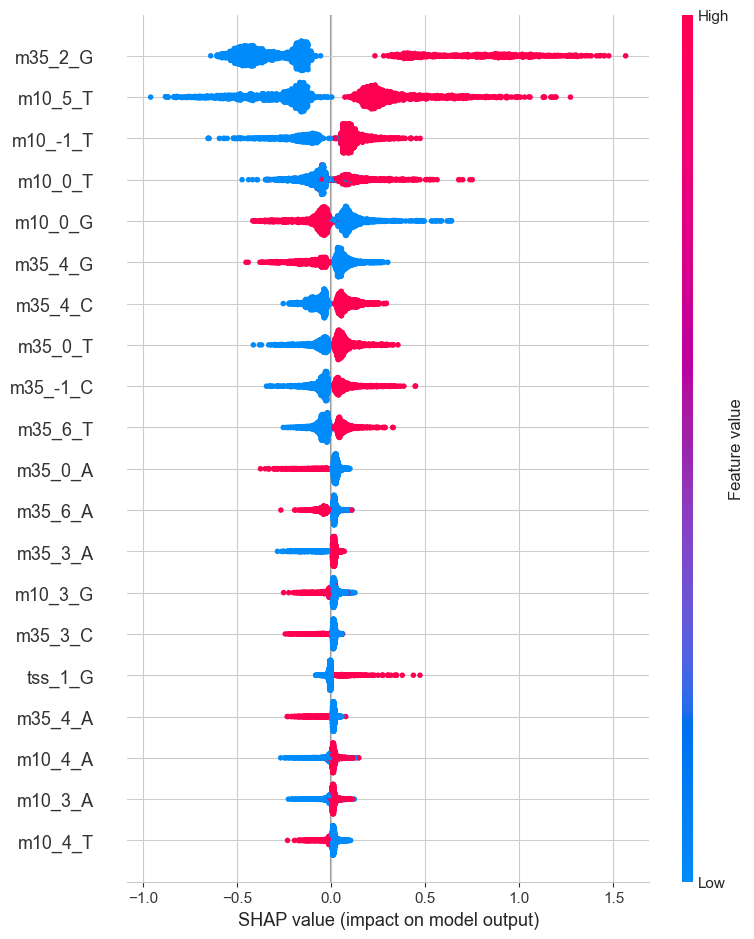

In [128]:
max_evals = 1000
feature_importance(seed_set, max_evals,
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF'],
    #models_to_try['ElasticNet'],
    #"elastic net" #Put tree if tree
)

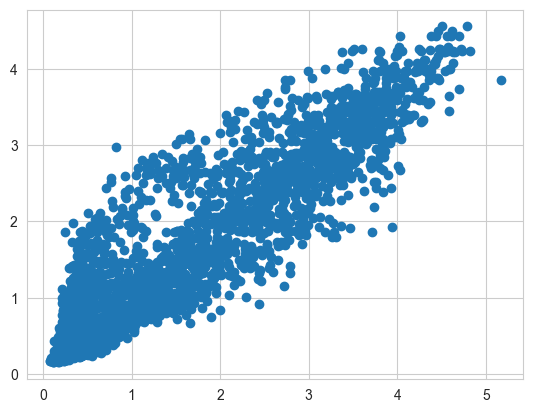

In [201]:
#Setting up the train/test and fitting the model
#x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_raw, y_oh_fi_log, test_size=0.2, random_state = rng)
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_log, test_size=0.2, random_state = seed_set)

#Non hyperparameter optimized models
fit_model = models_to_try['RF'].fit(x_train, y_train)
#fit_model = models_to_try['ElasticNet'].fit(x_train, y_train)

#Hyperparameter optimized models
#Elastic Net
#fit_model = ElasticNetCV(cv=5, random_state=seed_set).fit(x_train, y_train) #This has hyperparameter optimization

#Random Forest
#This is currently limited - can extend to a more full set of features as described here: 
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 
#param_grid = {'max_depth': [2, 4, 6], 'min_samples_split': [2, 3, 4, 5, 6]}
#base_estimator = RandomForestRegressor(random_state=seed_set)
#sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5, factor=2, resource='n_estimators',max_resources=30).fit(x_train, y_train)
#fit_model = sh.best_estimator_

#XGBoost
#https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
#xgb_model = xgb.XGBRegressor(random_state=seed_set)
#param_dist = {
#    'max_depth': stats.randint(2, 8),
#    'learning_rate': stats.uniform(0.01, 0.1),
#    'subsample': stats.uniform(0.5, 0.5),
#    'n_estimators':stats.randint(2, 10)
#}
#random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5)#, scoring='accuracy')
#fit_model = random_search.fit(x_train, y_train)

plt.scatter(y_train,fit_model.predict(x_train))

Text(0.5, 0.05, 'R-square: 0.82\nPearson R: 0.91 (P=0.00E+00)\nSpearman R: 0.76 (P=0.00E+00)')

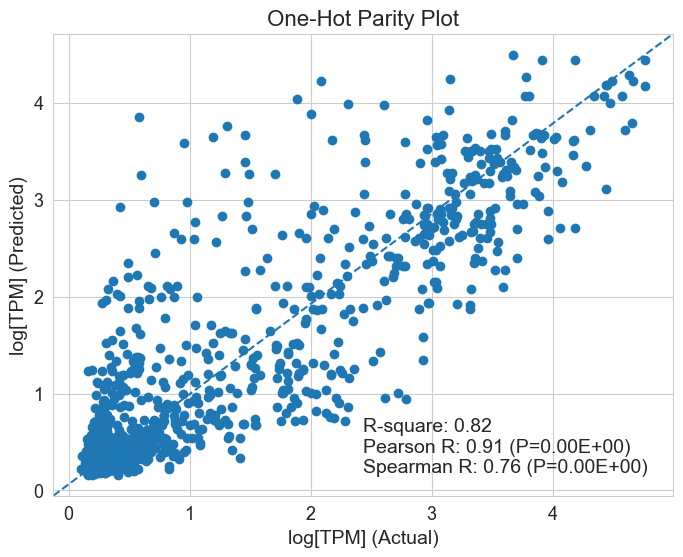

In [202]:
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
#y_pred_log = np.log2(y_pred + 1)
#y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

## Try on native data

In [207]:
x_oh_fi_raw_native = Xy_to_try_native['1tss__wt'][0]
x_oh_fi_std_native = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw_native),
    columns=x_oh_fi_raw_native.columns,
    index=x_oh_fi_raw_native.index
)
y_oh_fi_raw_native = Xy_to_try_native['1tss__wt'][1]
y_oh_fi_log_native = np.log2(y_oh_fi_raw_native.values + 1)

Text(0.5, 0.05, 'R-square: -3.35\nPearson R: 0.11 (P=5.31E-03)\nSpearman R: 0.10 (P=9.51E-03)')

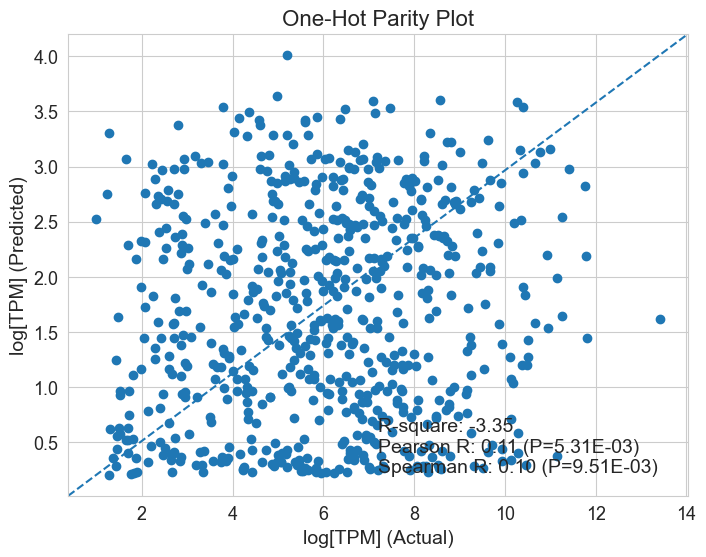

In [208]:
#Model performance
x_val_native = x_oh_fi_std_native
y_val_native = y_oh_fi_log_native

y_pred_native = fit_model.predict(x_val_native)

# plot actual (x) vs predicted (y) in a parity scatterplot
#y_pred_log = np.log2(y_pred + 1)
#y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val_native, y_pred_native)
pearson_r, pearson_p = pearsonr(y_val_native, y_pred_native)
spearman_r, spearman_p = spearmanr(y_val_native, y_pred_native)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val_native, y_pred_native)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

# (OLD) Multi-reference OHE Modeling

In [60]:
#one_hot_tus_local = mg1655.one_hot_encode_tu_promoters(local_align=False,n_upstream=50, n_downstream=10)
#one_hot_tus_local = one_hot_encode_tu_promoters(local_align=True, tss = True, tss_up = 50, tss_dn = 10, box_10_l=False, box_10_l_up = 15, box_10_l_dn = 20, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)
#one_hot_tus_local = one_hot_encode_tu_promoters(local_align=True, tss = True, tss_up = 5, tss_dn = 10, box_10_l=True, box_10_l_up = 5, box_10_l_dn = 10, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=True, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)
#Intentionally bad set
one_hot_tus_local = one_hot_encode_tu_promoters(local_align=True, tss = False, tss_up = 3, tss_dn = 3, box_10_l=True, box_10_l_up = 0, box_10_l_dn = 6, box_10_r=False, box_10_r_up = 5, box_10_r_dn = 15, box_35_l=False, box_35_l_up = 15, box_35_l_dn = 10, box_35_r=False, box_35_r_up = 5, box_35_r_dn = 5, spacer = False)

In [61]:
Xy_to_try = {}

gene_names_local_avg = []
gene_oh_rows_local_avg = []
gene_exps_local_avg = []
gene_exps_local_avg_ctrl = []
gene_exps_local_avg_all = []

gene_names_local_1tss = []
gene_oh_rows_local_1tss = []
gene_exps_local_1tss = []
gene_exps_local_1tss_ctrl = []
gene_exps_local_1tss_all = []

for gene_row in mg1655.gene_table.itertuples():
    
    # handle the local-aligned 1-hot
    tus_for_gene = mg1655._gene_to_tus[gene_row.Index]
    tus_in_oh_loc = [tu4g for tu4g in tus_for_gene if tu4g in list(one_hot_tus_local.index)]
    gene_tpm = gene_row.tpm
    gene_tpm_ctrl = gene_row.tpm_ctrl
    gene_tpm_all = gene_row.tpm_all
    #print(tus_in_oh_loc)
    if tus_in_oh_loc and not pd.isna(gene_tpm):
        
        # handle the one-hot averaging
        tu_one_hots_loc = one_hot_tus_local.loc[tus_in_oh_loc, :]
        tu_one_hot_avg_loc = tu_one_hots_loc.mean(axis=0)
        gene_names_local_avg.append(gene_row.Index)
        gene_oh_rows_local_avg.append(tu_one_hot_avg_loc)
        gene_exps_local_avg.append(gene_tpm)
        gene_exps_local_avg_ctrl.append(gene_tpm_ctrl)
        gene_exps_local_avg_all.append(gene_tpm_all)
        
        # handle the single-TSS case
        if len(tus_in_oh_loc) == 1:
            #print(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_names_local_1tss.append(gene_row.Index)
            gene_oh_rows_local_1tss.append(one_hot_tus_local.loc[tus_in_oh_loc[0]])
            gene_exps_local_1tss.append(gene_tpm)
            gene_exps_local_1tss_ctrl.append(gene_tpm_ctrl)
            gene_exps_local_1tss_all.append(gene_tpm_all)

X_local_avg = pd.DataFrame(gene_oh_rows_local_avg, index=gene_names_local_avg)
Xy_to_try['local_avg__wt'] = (X_local_avg, pd.Series(gene_exps_local_avg, index=gene_names_local_avg))
Xy_to_try['local_avg__ctrl'] = (X_local_avg, pd.Series(gene_exps_local_avg_ctrl, index=gene_names_local_avg))
Xy_to_try['local_avg__all'] = (X_local_avg, pd.Series(gene_exps_local_avg_all, index=gene_names_local_avg))

X_local_1tss = pd.DataFrame(gene_oh_rows_local_1tss, index=gene_names_local_1tss)
Xy_to_try['local_1tss__wt'] = (X_local_1tss, pd.Series(gene_exps_local_1tss, index=gene_names_local_1tss))
Xy_to_try['local_1tss__ctrl'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_ctrl, index=gene_names_local_1tss))
Xy_to_try['local_1tss__all'] = (X_local_1tss, pd.Series(gene_exps_local_1tss_all, index=gene_names_local_1tss))

In [62]:
#Reduce the set to just the 1tss and avg wt
Xy_to_try = {
    'local_1tss__wt': Xy_to_try['local_1tss__wt'],
    'local_avg__wt': Xy_to_try['local_avg__wt']
}

In [63]:
Xy_train, Xy_lockbox = create_train_and_lockbox_sets(Xy_to_try, random_state=42)

In [64]:
models_to_try = {
    #'ElasticNet': ElasticNet(),
    #'SVR': SVR(),
    'RF': RandomForestRegressor(n_jobs=4)
    #'NN': MLPRegressor()
}

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.


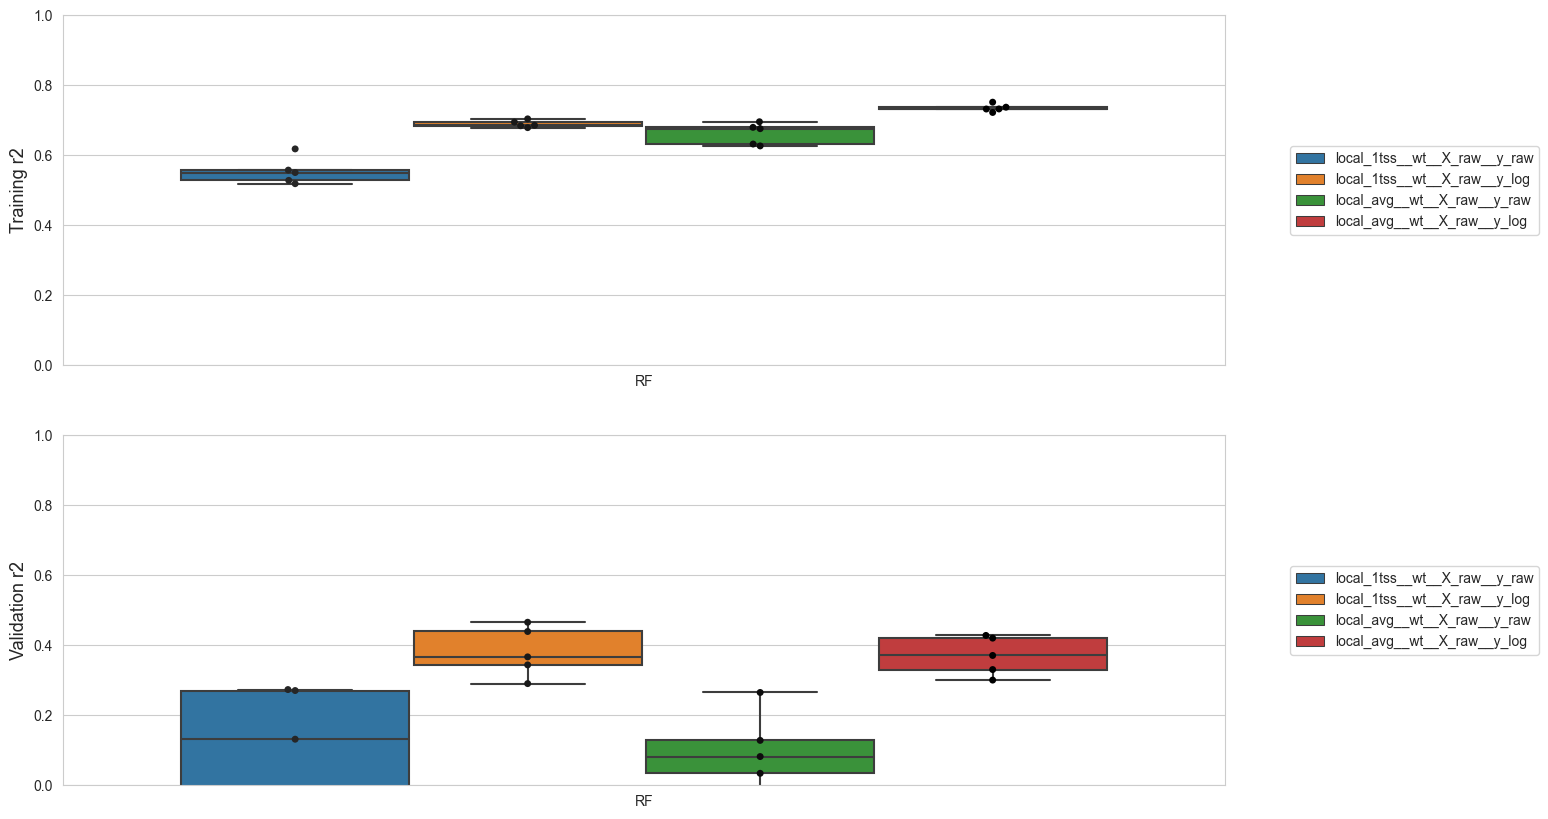

In [65]:
model_profile_df, ax_train, ax_val = profile_xy_and_models(Xy_train, models_to_try, scoring='r2', n_cv=5,
                                                           x_preprocessing=None, y_preprocessing=['log'],
                                                           verbose=False)

In [66]:
x_oh_fi_raw = Xy_train['local_1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['local_1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


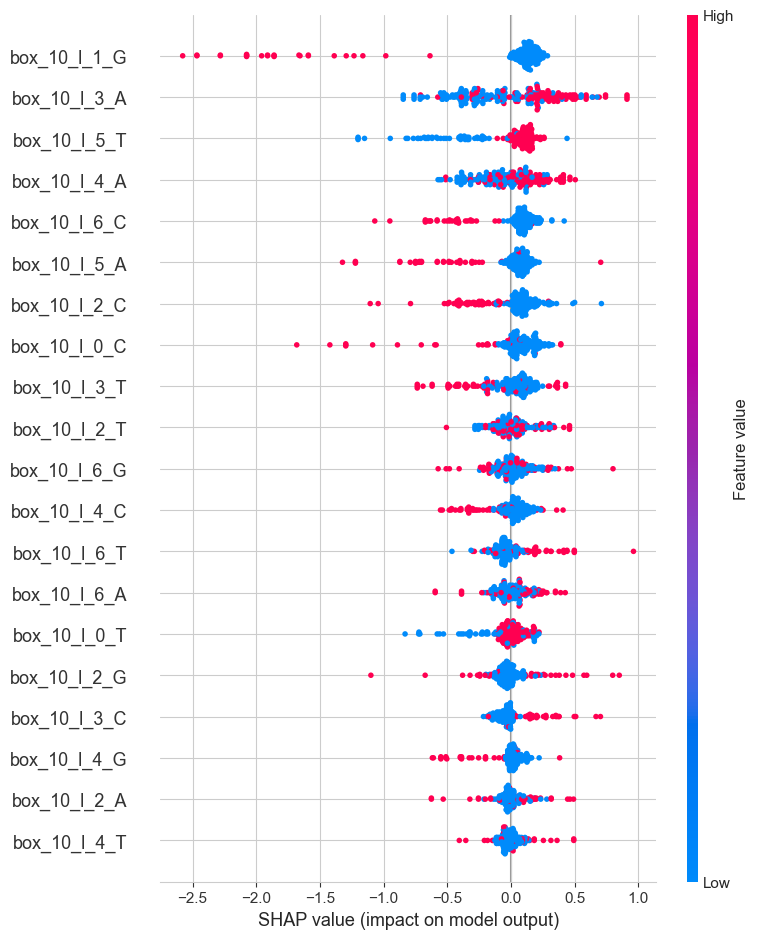

In [70]:
feature_importance(
    x_oh_fi_raw,
    y_oh_fi_log,
    models_to_try['RF']
    #models_to_try['ElasticNet']
)

In [68]:
#THIS IS A SCIKITLEARN FUNCTION THAT DOESN'T RESPECT TU STRUCTURE
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_raw, y_oh_fi_log, test_size=0.2, random_state = 42)

Text(0.5, 0.05, 'R-square: 0.34\nPearson R: 0.60 (P=9.50E-24)\nSpearman R: 0.56 (P=7.53E-20)')

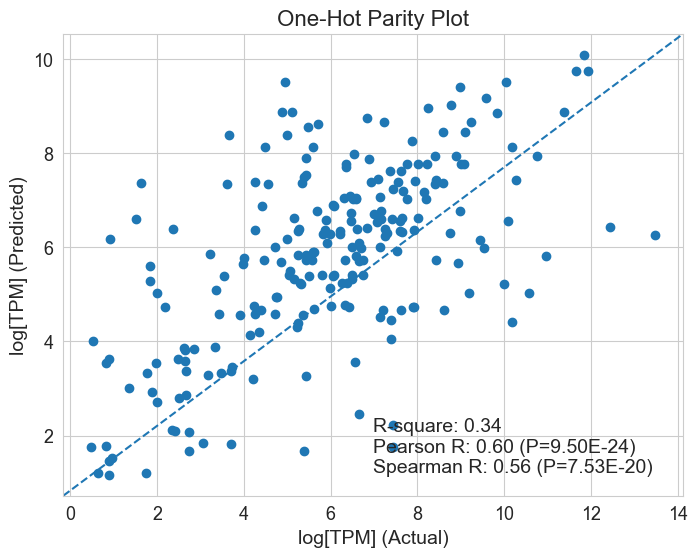

In [69]:
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot NOTE: IF THE Y_TRAIN IS LOG THIS IS UNNECESSARY
#y_pred_log = np.log2(y_pred + 1)
#y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

# Unused Model variants

In [74]:
'''
to_plot_df = model_profile_df[
    (model_profile_df['model'] == 'RF')
    #(model_profile_df['model'] == 'ElasticNet')
]

_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_train)
sns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_train)
ax_train.get_legend().remove()
ax_train.set_xlabel('')
ax_train.set_ylabel(f'Training R-squared', fontsize=13)
ax_train.set_ylim(0, 1)

sns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
            fliersize=0, ax=ax_val)
sns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,
              color='black', ax=ax_val)
handles_val, labels_val = ax_val.get_legend_handles_labels()
ax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],
              loc='lower left', bbox_to_anchor=(1.05, 0.1))
ax_val.set_xlabel('')
ax_val.set_ylabel(f'Validation R-squared', fontsize=13)
ax_val.set_ylim(0, 1)

sns.set_style('whitegrid')
'''

"\nto_plot_df = model_profile_df[\n    (model_profile_df['model'] == 'RF')\n    #(model_profile_df['model'] == 'ElasticNet')\n]\n\n_, (ax_train, ax_val) = plt.subplots(2, 1, figsize=(15, 10))\n\nsns.boxplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,\n            fliersize=0, ax=ax_train)\nsns.swarmplot(x='model', y='train_score', data=to_plot_df, hue='xy', dodge=True,\n              color='black', ax=ax_train)\nax_train.get_legend().remove()\nax_train.set_xlabel('')\nax_train.set_ylabel(f'Training R-squared', fontsize=13)\nax_train.set_ylim(0, 1)\n\nsns.boxplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,\n            fliersize=0, ax=ax_val)\nsns.swarmplot(x='model', y='val_score', data=to_plot_df, hue='xy', dodge=True,\n              color='black', ax=ax_val)\nhandles_val, labels_val = ax_val.get_legend_handles_labels()\nax_val.legend(handles_val[:int(len(handles_val)/2)], labels_val[:int(len(labels_val)/2)],\n              loc='lower left',

In [65]:
x_oh_fi_raw = Xy_train['local_1tss__wt'][0]
x_oh_fi_std = pd.DataFrame(
    StandardScaler().fit_transform(x_oh_fi_raw),
    columns=x_oh_fi_raw.columns,
    index=x_oh_fi_raw.index
)
y_oh_fi_raw = Xy_train['local_1tss__wt'][1]
y_oh_fi_log = np.log2(y_oh_fi_raw.values + 1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    fit_model = model.fit(x_train, y_train)

    if model_type == 'tree':
        explainer = shap.TreeExplainer(fit_model)
    else:
        explainer = shap.Explainer(fit_model)
    shap_values = explainer.shap_values(x_val)
    shap.summary_plot(shap_values, x_val)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


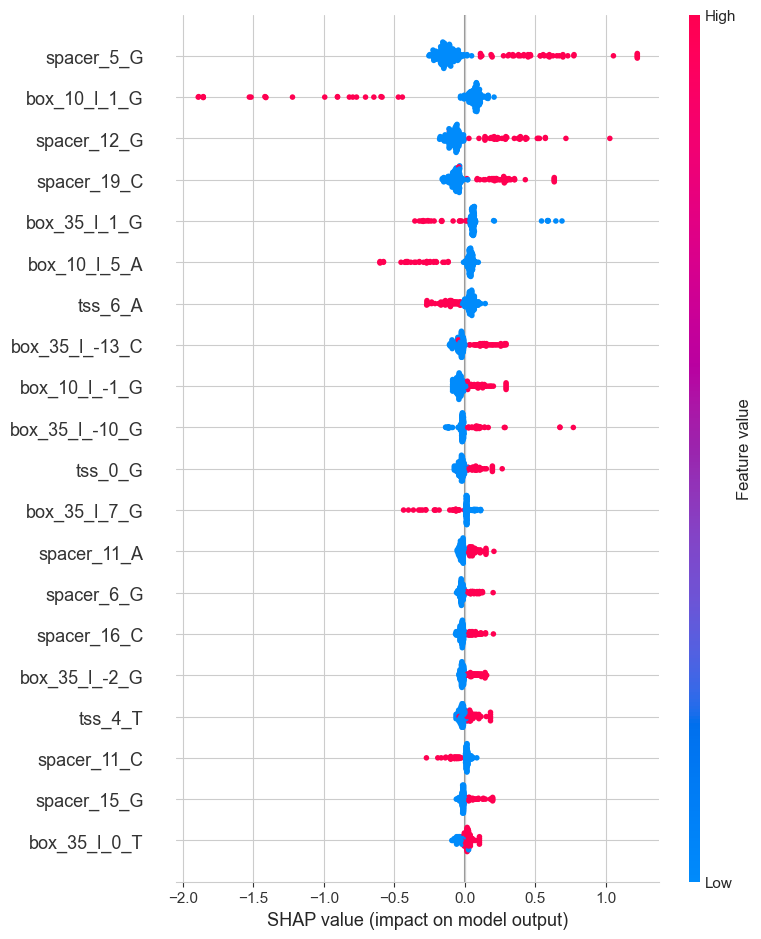

In [66]:
feature_importance(
    x_oh_fi_std,
    y_oh_fi_log,
    models_to_try['RF']
)

In [67]:
# split and fit the data with the given model; generate predictions
x_train, x_val, y_train, y_val = train_test_split(x_oh_fi_std, y_oh_fi_raw, test_size=0.2, random_state = 42)

Text(0.5, 0.05, 'R-square: 0.19\nPearson R: 0.43 (P=8.44E-12)\nSpearman R: 0.60 (P=6.40E-24)')

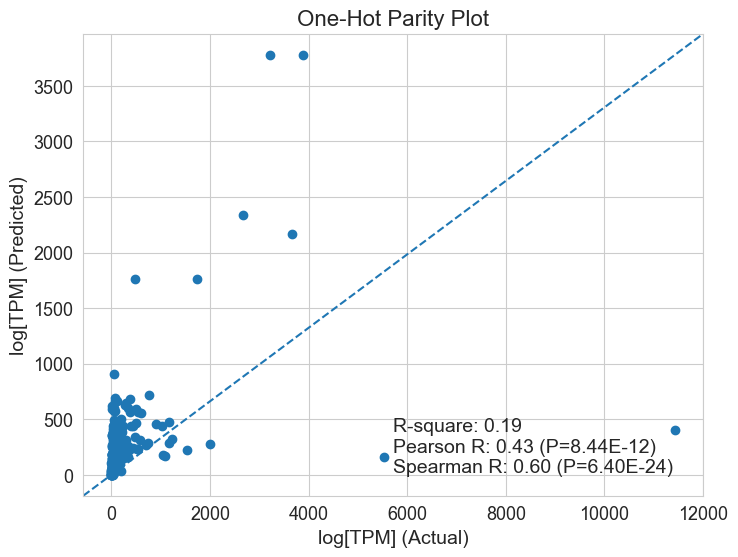

In [68]:
fit_model = models_to_try['RF'].fit(x_train, y_train)
y_pred = fit_model.predict(x_val)

# plot actual (x) vs predicted (y) in a parity scatterplot
y_pred_log = np.log2(y_pred + 1)
y_val_log = np.log2(y_val + 1)

r_squared = r2_score(y_val, y_pred)
pearson_r, pearson_p = pearsonr(y_val, y_pred)
spearman_r, spearman_p = spearmanr(y_val, y_pred)

_, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_val, y_pred)
ax.set_xlabel('log[TPM] (Actual)', fontsize=14)
ax.set_ylabel('log[TPM] (Predicted)', fontsize=14)
ax.plot([0, 1], [0, 1], linestyle='--', transform=ax.transAxes)
ax.tick_params(axis='both', labelsize=13)
ax.set_title('One-Hot Parity Plot', fontsize=16)
text = f'R-square: {r_squared:.2f}\nPearson R: {pearson_r:.2f} (P={pearson_p:.2E})\nSpearman R: {spearman_r:.2f} (P={spearman_p:.2E})'
ax.text(0.5, 0.05, text, transform=ax.transAxes, fontsize=14)

# Negative strand MROH Examination - grouping by transcription unit/promoter

#### Strand = -1

In [157]:
grouped_mini_dfs = {name: group for name, group in promoter_table.groupby('name')}
grouped_mini_dfs['astCADBE']

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
p_1832013,astCADBE,-1.0,1832013.0,Sigma70,1832022.0,1832027.0,1832047.0,1832052.0,1825955.0,1832013.0,6058.0


In [158]:
#change this to the promoter/TU name of choice
name_to_extract = 'astCADBE'
indexes_to_extract = grouped_mini_dfs.get(name_to_extract, pd.DataFrame()).index

#result_df = one_hot_all_local.loc[indexes_to_extract]
result_df = one_hot_all.loc[indexes_to_extract]

result_df

,tss_-1_A,tss_-1_C,tss_-1_G,tss_-1_T,tss_0_A,tss_0_C,tss_0_G,tss_0_T,tss_1_A,tss_1_C,...,box_35_l_5_G,box_35_l_5_T,box_35_l_6_A,box_35_l_6_C,box_35_l_6_G,box_35_l_6_T,box_35_l_7_A,box_35_l_7_C,box_35_l_7_G,box_35_l_7_T
p_1832013,0,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


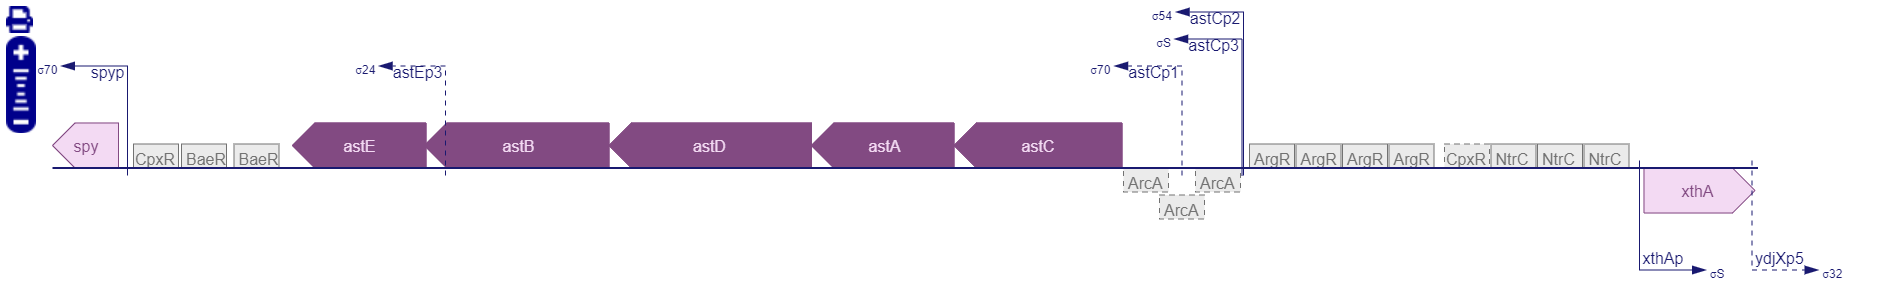

### Promoter: astCp1, tss: 1832013 

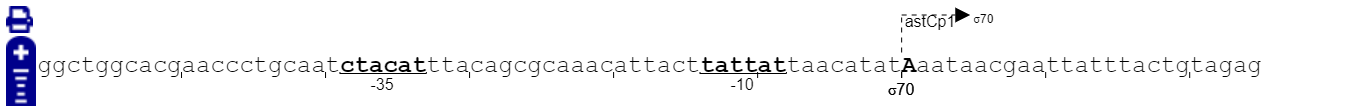

In [159]:
astCp1 = result_df.iloc[0]
filtered_values = astCp1[astCp1 == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-1_T
tss_0_A
tss_1_A
box_10_l_-2_C
box_10_l_-1_T
box_10_l_0_T
box_10_l_1_A
box_10_l_2_T
box_10_l_3_T
box_10_l_4_A
box_10_l_5_T
box_10_l_6_T
box_10_l_7_A
box_35_l_-2_A
box_35_l_-1_T
box_35_l_0_C
box_35_l_1_T
box_35_l_2_A
box_35_l_3_C
box_35_l_4_A
box_35_l_5_T
box_35_l_6_T
box_35_l_7_T


### Promoter: astCp2, tss: 1832044

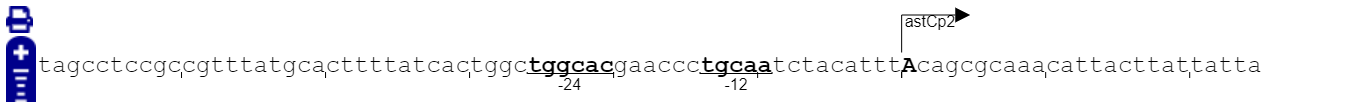

In [161]:
'''astCp2 = result_df.iloc[1]
filtered_values = astCp2[astCp2 == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)'''

'astCp2 = result_df.iloc[1]\nfiltered_values = astCp2[astCp2 == 1]\nfiltered_indices = filtered_values.index\nfor i in list(filtered_indices):\n    print(i)'

# Positive strand MROH Examination - grouping by transcription unit/promoter

#### Strand = 1

In [162]:
grouped_mini_dfs = {name: group for name, group in promoter_table.groupby('name')}
grouped_mini_dfs['nrdHIEF']

,name,strand,tss,sigma_factor,box_10_left,box_10_right,box_35_left,box_35_right,left,right,length
p_2800656,nrdHIEF,1.0,2800656.0,Sigma70,2800644.0,2800649.0,2800621.0,2800626.0,2800656.0,2804461.0,3805.0


In [164]:
#change this to the promoter/TU name of choice
name_to_extract = 'nrdHIEF'
indexes_to_extract = grouped_mini_dfs.get(name_to_extract, pd.DataFrame()).index

result_df = one_hot_all.loc[indexes_to_extract]

result_df

,tss_-1_A,tss_-1_C,tss_-1_G,tss_-1_T,tss_0_A,tss_0_C,tss_0_G,tss_0_T,tss_1_A,tss_1_C,...,box_35_l_5_G,box_35_l_5_T,box_35_l_6_A,box_35_l_6_C,box_35_l_6_G,box_35_l_6_T,box_35_l_7_A,box_35_l_7_C,box_35_l_7_G,box_35_l_7_T
p_2800656,0,0,0,1,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1


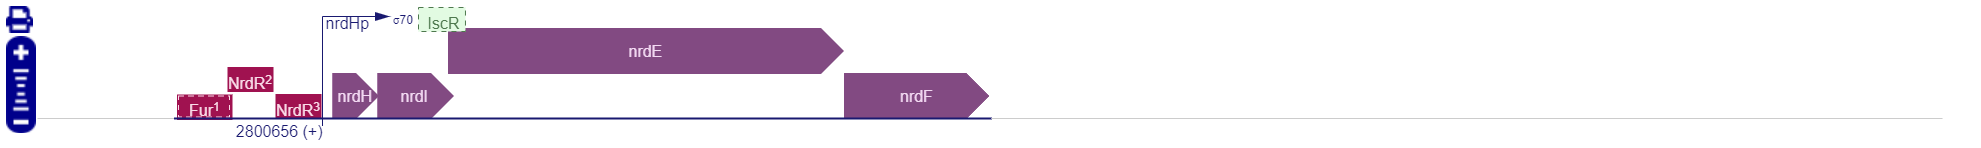

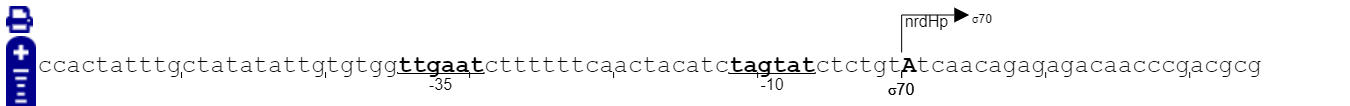

In [165]:
nrdHp = result_df.iloc[0]
filtered_values = nrdHp[nrdHp == 1]
filtered_indices = filtered_values.index
for i in list(filtered_indices):
    print(i)

tss_-1_T
tss_0_A
tss_1_T
box_10_l_-2_T
box_10_l_-1_C
box_10_l_0_T
box_10_l_1_A
box_10_l_2_G
box_10_l_3_T
box_10_l_4_A
box_10_l_5_T
box_10_l_6_C
box_10_l_7_T
box_35_l_-2_G
box_35_l_-1_G
box_35_l_0_T
box_35_l_1_T
box_35_l_2_G
box_35_l_3_A
box_35_l_4_A
box_35_l_5_T
box_35_l_6_C
box_35_l_7_T
